In [7]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy import concatenate
from math import sqrt
from statistics import mean
import random
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv('/Users/alexellard/Downloads/scenarios_data.csv', header=0, index_col=0)
df

,reservoir_demand,node_1_demand,node_2_demand,node_3_demand,node_4_demand,node_5_demand,node_6_demand,node_7_demand,node_8_demand,node_9_demand,...,link_23_flow,link_24_flow,link_25_flow,link_26_flow,link_27_flow,link_28_flow,link_29_flow,link_30_flow,link_31_flow,link_32_flow
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-3348.0,154.8,169.2,18.0,118.8,169.2,234.0,86.4,82.8,104.4,...,439.2,-205.2,-75.6,-18.0,118.8,68.4,7.2,-54.0,75.6,212.4
2017-01-01 00:30:00,-2959.2,136.8,147.6,18.0,108.0,144.0,237.6,79.2,75.6,90.0,...,392.4,-187.2,-72.0,-21.6,108.0,61.2,3.6,-54.0,72.0,183.6
2017-01-01 01:00:00,-2692.8,129.6,126.0,14.4,104.4,133.2,205.2,72.0,72.0,90.0,...,349.2,-176.4,-64.8,-18.0,93.6,50.4,3.6,-39.6,54.0,151.2
2017-01-01 01:30:00,-2379.6,104.4,100.8,10.8,86.4,122.4,180.0,68.4,57.6,82.8,...,316.8,-158.4,-54.0,-10.8,79.2,46.8,7.2,-32.4,50.4,140.4
2017-01-01 02:00:00,-2228.4,104.4,104.4,10.8,79.2,122.4,183.6,68.4,54.0,75.6,...,277.2,-144.0,-57.6,-18.0,72.0,39.6,7.2,-32.4,43.2,118.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 21:30:00,-5306.4,205.2,208.8,39.6,183.6,284.4,316.8,176.4,133.2,129.6,...,604.8,-259.2,32.4,115.2,169.2,100.8,10.8,-100.8,122.4,309.6
2017-12-31 22:00:00,-4910.4,208.8,183.6,39.6,154.8,252.0,295.2,165.6,133.2,133.2,...,565.2,-241.2,21.6,100.8,154.8,86.4,18.0,-75.6,100.8,288.0
2017-12-31 22:30:00,-4683.6,187.2,183.6,36.0,147.6,230.4,320.4,147.6,118.8,126.0,...,529.2,-226.8,21.6,100.8,147.6,86.4,14.4,-86.4,108.0,266.4


In [9]:
#average scores pressure node 29

MAE_average = []
RMSE_average = []
R2_average = []
maximum_MAE = []
sensors_covered = []
n_columns_to_drop = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
for n in n_columns_to_drop:
    MAE = []
    RMSE = []
    R2 = []
    for run in range(1,11):
        Y = df[df.columns[61]]
        X = df.drop(columns=['node_29_pressure'])
        X['node_29_pressure'] = Y
        columns = []
        columns_to_drop = random.sample(list(X.columns), n)
        # Drop the selected columns from the dataframe
        if X.columns[-1] in columns_to_drop:
            columns_to_drop.remove(X.columns[-1])
        X.drop(columns_to_drop, axis=1, inplace=True)
        columns.append(columns_to_drop)
        print(columns)
        print('starting df shape:', X.shape)
        print(f'This is training run {run} and has the shape: ', X.shape)
        print(f'The value of dropped columns is {n}')

        values = X.values
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
        train, test = train_test_split(scaled, test_size=0.2, random_state=0)

        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]

        #define model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42
        )

        # fit the model on the training data
        model.fit(train_X, train_y)

        # make predictions on the test data
        y_pred = model.predict(test_X)

        test_y = test_y.reshape((len(test_y), 1))
        print('test y shape :', test_y.shape)
        inv_test_y = concatenate((test_y, test_X[:, -X.shape[1]:]), axis=1)
        print('Inv y shape :', inv_test_y.shape)
        test_y_inverse = scaler.inverse_transform(inv_test_y)
        test_y_inverse = test_y_inverse[:,0]

        scaled = scaler.fit_transform(values)
        train, test = train_test_split(scaled, test_size=0.2, random_state=0)

        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]

        #define model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42
        )

        # fit the model on the training data
        model.fit(train_X, train_y)

        # make predictions on the test data
        y_pred = model.predict(test_X)

        test_y = test_y.reshape((len(test_y), 1))
        print('test y shape :', test_y.shape)
        inv_test_y = concatenate((test_y, test_X[:, -X.shape[1]:]), axis=1)
        print('Inv y shape :', inv_test_y.shape)
        test_y_inverse = scaler.inverse_transform(inv_test_y)
        test_y_inverse = test_y_inverse[:,0]

        y_pred = y_pred.reshape((len(y_pred), 1))
        print('y pred shape :', y_pred.shape)
        inv_y_pred = concatenate((y_pred, test_X[:, -X.shape[1]:]), axis=1)
        print('inv y pred :', inv_y_pred.shape)
        y_pred_inverse = scaler.inverse_transform(inv_y_pred)
        y_pred_inverse = y_pred_inverse[:,0]

        # evaluate scaled errors
        mae_inverse = mean_absolute_error(test_y_inverse, y_pred_inverse)
        MAE.append(mae_inverse)
        print(f'Run {run} Mean Absolute Error:', mae_inverse)
        rmse_inverse = sqrt(mean_squared_error(test_y_inverse, y_pred_inverse))
        RMSE.append(rmse_inverse)
        print('RMSE: %.3f' % rmse_inverse)
        r2_inverse = r2_score(test_y_inverse, y_pred_inverse)
        R2.append(r2_inverse)
        print('R^2: %.3f' % r2_inverse)
    percentage_list = round(X.shape[1] / 96 * 100)
    sensors_covered.append(percentage_list)
    MAE_mean = mean(MAE)
    RMSE_mean = mean(RMSE)
    R2_mean = mean(R2)
    max_MAE = max(MAE)
    maximum_MAE.append(max_MAE)
    MAE_average.append(MAE_mean)
    RMSE_average.append(RMSE_mean)
    R2_average.append(R2_mean)
print('Length MAE_average: ', len(MAE_average))
print('Length sensors_covered: ', len(sensors_covered))

[[]]
starting df shape: (87600, 96)
This is training run 1 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 1 Mean Absolute Error: 2.7127859912848926
RMSE: 3.887
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 2 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 2 Mean Absolute Error: 2.7127859912848926
RMSE: 3.887
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 3 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 3 Mean Absolute Error: 2.7127859912848926
RMSE: 3.887
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 4 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 4 Mean Absolute Error: 2.7127859912848926
RMSE: 3.887
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 5 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 5 Mean Absolute Error: 2.7127859912848926
RMSE: 3.887
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 6 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 6 Mean Absolute Error: 2.7127859912848926
RMSE: 3.887
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 7 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 7 Mean Absolute Error: 2.7127859912848926
RMSE: 3.887
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 8 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 8 Mean Absolute Error: 2.7127859912848926
RMSE: 3.887
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 9 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 9 Mean Absolute Error: 2.7127859912848926
RMSE: 3.887
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 10 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 10 Mean Absolute Error: 2.7127859912848926
RMSE: 3.887
R^2: 1.000
[['node_2_pressure', 'node_8_demand', 'reservoir_pressure', 'node_24_demand', 'link_14_flow']]
starting df shape: (87600, 91)
This is training run 1 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 1 Mean Absolute Error: 3.1690392981250137
RMSE: 4.515
R^2: 1.000
[['link_24_flow', 'node_27_demand', 'link_6_flow', 'link_4_flow', 'node_28_demand']]
starting df shape: (87600, 91)
This is training run 2 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 2 Mean Absolute Error: 2.7879930276188367
RMSE: 3.938
R^2: 1.000
[['node_15_pressure', 'link_8_flow', 'node_14_pressure', 'node_11_demand', 'node_29_demand']]
starting df shape: (87600, 91)
This is training run 3 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 3 Mean Absolute Error: 3.194467609721415
RMSE: 4.600
R^2: 1.000
[['node_21_demand', 'node_30_pressure', 'link_32_flow', 'node_4_pressure', 'node_27_demand']]
starting df shape: (87600, 91)
This is training run 4 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 4 Mean Absolute Error: 4.016284019941274
RMSE: 5.505
R^2: 1.000
[['node_30_pressure', 'link_9_flow', 'node_16_demand', 'link_13_flow', 'link_24_flow']]
starting df shape: (87600, 91)
This is training run 5 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 5 Mean Absolute Error: 4.127677764270542
RMSE: 5.697
R^2: 1.000
[['node_18_demand', 'link_21_flow', 'link_14_flow', 'reservoir_demand', 'node_3_demand']]
starting df shape: (87600, 91)
This is training run 6 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 6 Mean Absolute Error: 0.16825321437182775
RMSE: 0.241
R^2: 1.000
[['node_19_pressure', 'node_2_pressure', 'node_16_demand', 'node_23_demand', 'link_21_flow']]
starting df shape: (87600, 91)
This is training run 7 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 7 Mean Absolute Error: 3.170550681500926
RMSE: 4.479
R^2: 1.000
[['node_30_pressure', 'node_27_pressure', 'node_16_pressure', 'node_1_pressure', 'link_29_flow']]
starting df shape: (87600, 91)
This is training run 8 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 8 Mean Absolute Error: 4.127425334277181
RMSE: 5.671
R^2: 1.000
[['node_1_pressure', 'link_26_flow', 'node_15_pressure', 'link_32_flow', 'link_3_flow']]
starting df shape: (87600, 91)
This is training run 9 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 9 Mean Absolute Error: 2.758656203457769
RMSE: 3.943
R^2: 1.000
[['link_30_flow', 'node_22_demand', 'link_2_flow', 'node_19_pressure', 'link_16_flow']]
starting df shape: (87600, 91)
This is training run 10 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 10 Mean Absolute Error: 2.819444349969588
RMSE: 3.988
R^2: 1.000
[['node_10_demand', 'node_1_demand', 'node_8_demand', 'node_3_demand', 'link_8_flow', 'node_2_pressure', 'node_19_demand', 'link_3_flow', 'link_17_flow', 'link_30_flow']]
starting df shape: (87600, 86)
This is training run 1 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 1 Mean Absolute Error: 3.371113372965459
RMSE: 4.787
R^2: 1.000
[['reservoir_demand', 'link_24_flow', 'node_12_pressure', 'link_31_flow', 'link_16_flow', 'node_23_pressure', 'node_8_pressure', 'node_18_pressure', 'node_13_demand', 'node_10_pressure']]
starting df shape: (87600, 86)
This is training run 2 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 2 Mean Absolute Error: 0.19363287193247264
RMSE: 0.284
R^2: 1.000
[['node_15_pressure', 'node_25_demand', 'node_2_pressure', 'link_18_flow', 'node_26_pressure', 'node_12_pressure', 'node_20_demand', 'link_27_flow', 'node_5_demand', 'node_17_demand']]
starting df shape: (87600, 86)
This is training run 3 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 3 Mean Absolute Error: 2.993645450479258
RMSE: 4.259
R^2: 1.000
[['node_8_demand', 'node_17_pressure', 'node_28_pressure', 'node_25_pressure', 'node_11_demand', 'link_27_flow', 'link_31_flow', 'node_19_demand', 'node_12_pressure', 'node_27_demand']]
starting df shape: (87600, 86)
This is training run 4 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 4 Mean Absolute Error: 3.3072865468487556
RMSE: 4.525
R^2: 1.000
[['reservoir_pressure', 'node_12_demand', 'node_26_pressure', 'link_22_flow', 'node_9_demand', 'node_15_pressure', 'node_9_pressure', 'node_10_pressure', 'link_14_flow', 'node_20_pressure']]
starting df shape: (87600, 86)
This is training run 5 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 5 Mean Absolute Error: 2.993803781644613
RMSE: 4.271
R^2: 1.000
[['link_14_flow', 'node_27_demand', 'node_13_pressure', 'link_28_flow', 'node_20_demand', 'node_17_pressure', 'node_7_demand', 'node_11_pressure', 'node_28_demand', 'link_3_flow']]
starting df shape: (87600, 86)
This is training run 6 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 6 Mean Absolute Error: 3.153662140569265
RMSE: 4.617
R^2: 1.000
[['link_22_flow', 'node_28_pressure', 'node_22_demand', 'node_30_demand', 'link_7_flow', 'link_15_flow', 'link_16_flow', 'link_24_flow', 'link_25_flow', 'node_12_demand']]
starting df shape: (87600, 86)
This is training run 7 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 7 Mean Absolute Error: 3.313474909764554
RMSE: 4.657
R^2: 1.000
[['node_31_pressure', 'link_3_flow', 'node_19_pressure', 'link_27_flow', 'node_28_demand', 'link_11_flow', 'node_1_demand', 'link_24_flow', 'node_22_demand', 'node_28_pressure']]
starting df shape: (87600, 86)
This is training run 8 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 8 Mean Absolute Error: 3.765398949098878
RMSE: 5.201
R^2: 1.000
[['link_5_flow', 'node_8_demand', 'node_24_pressure', 'link_23_flow', 'node_7_pressure', 'node_11_demand', 'node_16_pressure', 'node_2_demand', 'link_3_flow', 'node_30_demand']]
starting df shape: (87600, 86)
This is training run 9 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 9 Mean Absolute Error: 3.208553808871412
RMSE: 4.666
R^2: 1.000
[['node_11_demand', 'link_19_flow', 'node_8_pressure', 'link_29_flow', 'node_9_demand', 'link_1_flow', 'node_26_demand', 'node_29_demand', 'link_10_flow']]
starting df shape: (87600, 87)
This is training run 10 and has the shape:  (87600, 87)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 87)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 87)
y pred shape : (17520, 1)
inv y pred : (17520, 87)
Run 10 Mean Absolute Error: 2.895926623012544
RMSE: 4.129
R^2: 1.000
[['link_6_flow', 'node_16_demand', 'node_24_demand', 'link_25_flow', 'link_3_flow', 'node_15_demand', 'node_12_pressure', 'node_8_pressure', 'node_18_pressure', 'node_14_demand', 'node_30_demand', 'node_23_demand', 'node_21_pressure', 'node_31_pressure', 'node_13_pressure']]
starting df shape: (87600, 81)
This is training run 1 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 1 Mean Absolute Error: 3.0435230143377545
RMSE: 4.262
R^2: 1.000
[['node_3_demand', 'link_8_flow', 'reservoir_demand', 'link_17_flow', 'link_25_flow', 'node_27_demand', 'node_12_demand', 'node_13_pressure', 'link_26_flow', 'node_8_demand', 'node_26_pressure', 'link_11_flow', 'node_7_demand', 'node_18_pressure']]
starting df shape: (87600, 82)
This is training run 2 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 2 Mean Absolute Error: 0.16818475341796457
RMSE: 0.245
R^2: 1.000
[['node_20_pressure', 'node_31_demand', 'node_3_demand', 'reservoir_pressure', 'node_10_pressure', 'node_14_demand', 'node_27_demand', 'link_21_flow', 'link_4_flow', 'node_5_pressure', 'node_22_pressure', 'node_7_demand', 'link_29_flow', 'link_30_flow', 'node_21_demand']]
starting df shape: (87600, 81)
This is training run 3 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 3 Mean Absolute Error: 2.942811743718833
RMSE: 4.187
R^2: 1.000
[['node_16_demand', 'node_30_demand', 'node_12_pressure', 'link_20_flow', 'node_11_demand', 'node_21_demand', 'node_26_demand', 'node_7_pressure', 'node_4_pressure', 'node_5_pressure', 'link_5_flow', 'link_26_flow', 'node_12_demand', 'node_3_demand']]
starting df shape: (87600, 82)
This is training run 4 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 4 Mean Absolute Error: 2.8324082061469222
RMSE: 4.175
R^2: 1.000
[['node_12_demand', 'node_24_demand', 'node_13_pressure', 'link_12_flow', 'node_24_pressure', 'link_6_flow', 'node_15_demand', 'link_28_flow', 'node_2_demand', 'node_31_demand', 'node_25_pressure', 'node_23_demand', 'node_17_pressure', 'link_21_flow', 'node_7_demand']]
starting df shape: (87600, 81)
This is training run 5 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 5 Mean Absolute Error: 2.848291086837965
RMSE: 4.076
R^2: 1.000
[['node_27_pressure', 'node_4_pressure', 'node_18_demand', 'link_25_flow', 'node_24_demand', 'node_2_pressure', 'node_6_pressure', 'node_12_pressure', 'node_1_pressure', 'node_10_pressure', 'node_14_demand', 'link_18_flow', 'node_13_pressure', 'node_20_pressure', 'node_24_pressure']]
starting df shape: (87600, 81)
This is training run 6 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 6 Mean Absolute Error: 2.715213480354837
RMSE: 3.901
R^2: 1.000
[['node_8_pressure', 'link_14_flow', 'link_7_flow', 'node_24_pressure', 'node_12_demand', 'link_20_flow', 'link_11_flow', 'link_12_flow', 'link_32_flow', 'link_13_flow', 'node_4_demand', 'node_29_demand', 'node_27_pressure', 'node_17_demand']]
starting df shape: (87600, 82)
This is training run 7 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 7 Mean Absolute Error: 3.327213454694209
RMSE: 4.864
R^2: 1.000
[['node_28_pressure', 'link_25_flow', 'node_21_demand', 'link_23_flow', 'node_2_pressure', 'node_13_demand', 'node_27_demand', 'node_13_pressure', 'node_5_demand', 'node_29_demand', 'node_21_pressure', 'node_4_pressure', 'link_18_flow', 'node_14_pressure']]
starting df shape: (87600, 82)
This is training run 8 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 8 Mean Absolute Error: 3.0024824261376484
RMSE: 4.273
R^2: 1.000
[['link_11_flow', 'link_22_flow', 'node_8_demand', 'node_10_demand', 'link_30_flow', 'link_10_flow', 'node_17_pressure', 'link_21_flow', 'node_18_demand', 'node_26_demand', 'node_31_pressure', 'node_31_demand', 'node_5_pressure', 'link_26_flow']]
starting df shape: (87600, 82)
This is training run 9 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 9 Mean Absolute Error: 3.621946693376064
RMSE: 5.225
R^2: 1.000
[['node_23_demand', 'node_22_demand', 'link_25_flow', 'link_30_flow', 'node_1_demand', 'node_2_demand', 'link_11_flow', 'link_20_flow', 'node_8_pressure', 'node_11_demand', 'node_13_pressure', 'node_16_demand', 'link_14_flow', 'node_3_demand', 'node_23_pressure']]
starting df shape: (87600, 81)
This is training run 10 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 10 Mean Absolute Error: 2.8403470128800468
RMSE: 4.184
R^2: 1.000
[['link_1_flow', 'node_9_pressure', 'node_25_demand', 'link_19_flow', 'node_27_pressure', 'node_17_demand', 'node_3_demand', 'link_12_flow', 'link_18_flow', 'node_31_pressure', 'node_2_demand', 'node_22_demand', 'link_5_flow', 'node_8_pressure', 'reservoir_pressure', 'link_8_flow', 'link_7_flow', 'node_26_pressure', 'link_11_flow', 'node_25_pressure']]
starting df shape: (87600, 76)
This is training run 1 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 1 Mean Absolute Error: 2.673496207720841
RMSE: 3.824
R^2: 1.000
[['node_9_demand', 'node_12_pressure', 'node_18_demand', 'node_20_pressure', 'node_28_demand', 'node_11_pressure', 'node_31_pressure', 'link_11_flow', 'link_13_flow', 'node_18_pressure', 'node_12_demand', 'node_24_demand', 'node_3_demand', 'link_9_flow', 'node_15_pressure', 'node_5_demand', 'node_26_pressure', 'node_8_demand', 'node_23_pressure', 'link_4_flow']]
starting df shape: (87600, 76)
This is training run 2 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 2 Mean Absolute Error: 3.0572814301941644
RMSE: 4.378
R^2: 1.000
[['link_28_flow', 'link_13_flow', 'reservoir_demand', 'node_9_demand', 'node_17_demand', 'link_6_flow', 'node_8_pressure', 'link_19_flow', 'node_15_demand', 'node_29_demand', 'link_27_flow', 'node_8_demand', 'link_1_flow', 'node_2_pressure', 'node_12_demand', 'node_14_demand', 'link_15_flow', 'node_23_demand', 'node_25_pressure', 'node_7_demand']]
starting df shape: (87600, 76)
This is training run 3 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 3 Mean Absolute Error: 0.16681342750021502
RMSE: 0.242
R^2: 1.000
[['link_16_flow', 'node_19_pressure', 'node_3_pressure', 'node_24_demand', 'node_12_demand', 'link_4_flow', 'node_20_demand', 'node_10_pressure', 'node_16_demand', 'link_10_flow', 'node_22_pressure', 'node_14_demand', 'link_24_flow', 'node_21_demand', 'node_18_demand', 'link_12_flow', 'node_18_pressure', 'link_26_flow', 'reservoir_pressure', 'node_28_demand']]
starting df shape: (87600, 76)
This is training run 4 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 4 Mean Absolute Error: 3.126277921052479
RMSE: 4.487
R^2: 1.000
[['node_24_demand', 'link_16_flow', 'node_30_demand', 'link_32_flow', 'node_9_demand', 'node_18_pressure', 'node_11_pressure', 'node_3_pressure', 'node_12_pressure', 'link_17_flow', 'node_22_demand', 'node_26_demand', 'link_1_flow', 'node_4_demand', 'node_14_demand', 'node_13_demand', 'node_6_pressure', 'link_29_flow', 'node_6_demand', 'node_11_demand']]
starting df shape: (87600, 76)
This is training run 5 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 5 Mean Absolute Error: 3.0513975817599754
RMSE: 4.426
R^2: 1.000
[['node_6_pressure', 'node_16_demand', 'node_12_demand', 'node_26_pressure', 'link_5_flow', 'node_11_pressure', 'link_31_flow', 'node_4_pressure', 'node_23_demand', 'link_21_flow', 'node_9_pressure', 'node_10_pressure', 'node_9_demand', 'node_8_pressure', 'node_22_pressure', 'node_18_demand', 'node_31_demand', 'node_6_demand', 'link_2_flow', 'node_20_pressure']]
starting df shape: (87600, 76)
This is training run 6 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 6 Mean Absolute Error: 2.68713339278864
RMSE: 3.837
R^2: 1.000
[['node_12_demand', 'link_1_flow', 'node_31_demand', 'node_26_pressure', 'node_26_demand', 'link_22_flow', 'node_19_pressure', 'node_25_pressure', 'node_28_pressure', 'link_8_flow', 'link_19_flow', 'link_13_flow', 'node_30_demand', 'node_14_demand', 'link_10_flow', 'node_11_pressure', 'link_32_flow', 'link_30_flow', 'node_9_demand', 'link_17_flow']]
starting df shape: (87600, 76)
This is training run 7 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 7 Mean Absolute Error: 2.7766015373373656
RMSE: 3.983
R^2: 1.000
[['link_25_flow', 'node_7_pressure', 'reservoir_demand', 'link_14_flow', 'node_22_demand', 'node_25_pressure', 'node_5_pressure', 'node_18_demand', 'node_4_pressure', 'node_4_demand', 'node_6_pressure', 'node_31_demand', 'node_19_pressure', 'node_25_demand', 'node_29_demand', 'node_5_demand', 'node_3_pressure', 'node_3_demand', 'link_11_flow', 'node_22_pressure']]
starting df shape: (87600, 76)
This is training run 8 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 8 Mean Absolute Error: 0.16777704931037296
RMSE: 0.246
R^2: 1.000
[['link_6_flow', 'node_5_pressure', 'node_24_pressure', 'link_20_flow', 'node_1_demand', 'link_22_flow', 'reservoir_pressure', 'node_31_demand', 'node_8_pressure', 'node_23_pressure', 'link_15_flow', 'link_8_flow', 'link_28_flow', 'node_18_demand', 'node_11_demand', 'node_19_demand', 'node_2_pressure', 'link_21_flow', 'node_6_pressure']]
starting df shape: (87600, 77)
This is training run 9 and has the shape:  (87600, 77)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)
y pred shape : (17520, 1)
inv y pred : (17520, 77)
Run 9 Mean Absolute Error: 2.7850722338133482
RMSE: 4.044
R^2: 1.000
[['link_26_flow', 'link_30_flow', 'node_9_demand', 'link_10_flow', 'link_12_flow', 'node_15_demand', 'node_2_pressure', 'reservoir_pressure', 'node_7_pressure', 'node_4_demand', 'node_20_demand', 'node_28_demand', 'node_12_pressure', 'link_25_flow', 'node_16_demand', 'link_22_flow', 'link_23_flow', 'node_27_pressure', 'node_10_demand', 'node_13_demand']]
starting df shape: (87600, 76)
This is training run 10 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 10 Mean Absolute Error: 2.714541932553677
RMSE: 3.950
R^2: 1.000
[['node_2_demand', 'node_7_demand', 'node_16_demand', 'node_24_pressure', 'node_3_pressure', 'node_10_pressure', 'node_23_demand', 'link_10_flow', 'reservoir_pressure', 'reservoir_demand', 'node_13_demand', 'node_27_demand', 'node_19_pressure', 'link_20_flow', 'link_26_flow', 'node_30_demand', 'node_6_pressure', 'link_19_flow', 'node_3_demand', 'node_26_demand', 'node_25_demand', 'node_28_pressure', 'node_17_pressure', 'node_13_pressure']]
starting df shape: (87600, 72)
This is training run 1 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 1 Mean Absolute Error: 0.17586296308720134
RMSE: 0.250
R^2: 1.000
[['node_2_demand', 'node_29_demand', 'link_19_flow', 'node_16_pressure', 'node_25_pressure', 'node_15_pressure', 'node_26_pressure', 'node_14_pressure', 'node_12_pressure', 'node_1_pressure', 'node_30_demand', 'link_21_flow', 'link_3_flow', 'link_23_flow', 'node_9_demand', 'link_27_flow', 'node_27_pressure', 'node_25_demand', 'reservoir_demand', 'node_31_pressure', 'link_16_flow', 'node_17_pressure', 'node_10_pressure', 'link_31_flow', 'node_15_demand']]
starting df shape: (87600, 71)
This is training run 2 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 2 Mean Absolute Error: 0.17831954466707248
RMSE: 0.261
R^2: 1.000
[['node_13_demand', 'node_31_demand', 'node_28_pressure', 'node_6_demand', 'link_15_flow', 'node_22_pressure', 'link_29_flow', 'link_12_flow', 'link_10_flow', 'node_21_demand', 'node_15_pressure', 'link_5_flow', 'link_26_flow', 'link_1_flow', 'link_7_flow', 'node_12_pressure', 'node_24_pressure', 'node_14_pressure', 'node_11_pressure', 'link_13_flow', 'node_5_pressure', 'node_5_demand', 'node_19_demand', 'link_19_flow', 'node_17_pressure']]
starting df shape: (87600, 71)
This is training run 3 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 3 Mean Absolute Error: 3.66155927723601
RMSE: 5.164
R^2: 1.000
[['link_11_flow', 'node_13_demand', 'node_15_pressure', 'link_20_flow', 'reservoir_demand', 'node_1_pressure', 'link_3_flow', 'link_19_flow', 'node_8_pressure', 'node_15_demand', 'node_11_pressure', 'link_26_flow', 'link_30_flow', 'link_8_flow', 'node_27_pressure', 'link_24_flow', 'node_31_demand', 'link_9_flow', 'node_19_pressure', 'node_8_demand', 'link_23_flow', 'node_24_demand', 'node_22_demand', 'node_17_pressure', 'link_22_flow']]
starting df shape: (87600, 71)
This is training run 4 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 4 Mean Absolute Error: 0.17522243148826963
RMSE: 0.256
R^2: 1.000
[['reservoir_pressure', 'node_1_pressure', 'link_32_flow', 'node_31_pressure', 'node_2_demand', 'node_2_pressure', 'node_7_demand', 'link_14_flow', 'node_8_demand', 'link_6_flow', 'link_17_flow', 'node_15_pressure', 'link_18_flow', 'link_15_flow', 'link_13_flow', 'node_5_demand', 'node_16_pressure', 'node_30_demand', 'link_8_flow', 'node_29_demand', 'node_23_demand', 'link_31_flow', 'node_18_pressure', 'node_11_demand', 'link_24_flow']]
starting df shape: (87600, 71)
This is training run 5 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 5 Mean Absolute Error: 3.102904918182836
RMSE: 4.350
R^2: 1.000
[['node_19_demand', 'node_20_pressure', 'node_16_pressure', 'link_24_flow', 'node_12_demand', 'node_2_pressure', 'node_1_demand', 'link_32_flow', 'link_29_flow', 'link_15_flow', 'link_27_flow', 'node_9_pressure', 'node_19_pressure', 'link_4_flow', 'link_2_flow', 'node_15_pressure', 'link_20_flow', 'node_6_demand', 'node_22_demand', 'link_21_flow', 'link_26_flow', 'node_29_demand', 'node_27_demand', 'node_4_pressure']]
starting df shape: (87600, 72)
This is training run 6 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 6 Mean Absolute Error: 3.189055719192776
RMSE: 4.507
R^2: 1.000
[['node_24_demand', 'link_5_flow', 'link_10_flow', 'node_28_pressure', 'node_30_pressure', 'link_21_flow', 'node_27_pressure', 'node_5_demand', 'node_12_demand', 'node_30_demand', 'link_22_flow', 'node_11_pressure', 'link_28_flow', 'node_10_pressure', 'node_4_demand', 'node_1_pressure', 'node_7_pressure', 'node_5_pressure', 'reservoir_demand', 'node_14_pressure', 'node_16_demand', 'link_25_flow', 'node_13_pressure', 'link_14_flow', 'node_23_demand']]
starting df shape: (87600, 71)
This is training run 7 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 7 Mean Absolute Error: 0.2922552375919271
RMSE: 0.395
R^2: 1.000
[['node_16_pressure', 'node_4_demand', 'node_31_demand', 'link_32_flow', 'node_3_pressure', 'node_11_pressure', 'node_14_pressure', 'node_12_pressure', 'node_4_pressure', 'node_15_demand', 'node_22_demand', 'link_13_flow', 'node_23_pressure', 'node_1_pressure', 'node_19_pressure', 'node_16_demand', 'node_27_pressure', 'node_13_pressure', 'node_8_demand', 'node_6_demand', 'node_6_pressure', 'link_16_flow', 'node_2_demand', 'link_27_flow', 'link_30_flow']]
starting df shape: (87600, 71)
This is training run 8 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 8 Mean Absolute Error: 2.6595793721848398
RMSE: 3.916
R^2: 1.000
[['node_9_demand', 'node_10_demand', 'link_19_flow', 'node_1_demand', 'node_26_pressure', 'link_30_flow', 'node_25_demand', 'node_14_demand', 'node_22_demand', 'node_6_demand', 'node_30_demand', 'node_13_pressure', 'link_3_flow', 'link_7_flow', 'link_27_flow', 'link_28_flow', 'node_5_demand', 'node_22_pressure', 'link_22_flow', 'node_10_pressure', 'node_11_demand', 'node_18_demand', 'node_7_pressure', 'node_9_pressure', 'node_4_demand']]
starting df shape: (87600, 71)
This is training run 9 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 9 Mean Absolute Error: 2.734849698893191
RMSE: 3.978
R^2: 1.000
[['link_6_flow', 'node_14_pressure', 'node_7_pressure', 'node_27_pressure', 'link_13_flow', 'link_23_flow', 'link_15_flow', 'node_10_pressure', 'link_9_flow', 'link_12_flow', 'link_19_flow', 'node_23_demand', 'node_5_pressure', 'node_15_demand', 'node_8_demand', 'link_10_flow', 'link_30_flow', 'node_28_pressure', 'link_14_flow', 'link_28_flow', 'node_24_pressure', 'node_2_demand', 'link_25_flow', 'node_7_demand']]
starting df shape: (87600, 72)
This is training run 10 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 10 Mean Absolute Error: 3.636256676290502
RMSE: 5.073
R^2: 1.000
[['node_7_demand', 'node_8_demand', 'node_8_pressure', 'node_9_demand', 'link_18_flow', 'reservoir_demand', 'node_13_pressure', 'node_9_pressure', 'node_24_pressure', 'link_16_flow', 'link_26_flow', 'node_20_pressure', 'node_31_demand', 'node_6_pressure', 'link_24_flow', 'link_7_flow', 'node_21_demand', 'node_10_pressure', 'node_20_demand', 'node_22_demand', 'node_17_demand', 'node_30_demand', 'node_23_demand', 'node_21_pressure', 'node_22_pressure', 'link_17_flow', 'node_28_pressure', 'node_1_pressure', 'node_16_pressure', 'node_4_demand']]
starting df shape: (87600, 66)
This is training run 1 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 1 Mean Absolute Error: 0.1960656041358375
RMSE: 0.276
R^2: 1.000
[['link_3_flow', 'link_26_flow', 'node_25_pressure', 'node_11_pressure', 'node_2_pressure', 'link_25_flow', 'node_8_pressure', 'node_22_demand', 'node_7_demand', 'node_5_demand', 'node_19_pressure', 'node_10_pressure', 'node_28_pressure', 'link_16_flow', 'node_24_pressure', 'link_10_flow', 'link_11_flow', 'node_4_pressure', 'node_15_demand', 'link_30_flow', 'node_1_pressure', 'node_24_demand', 'node_20_demand', 'node_23_pressure', 'node_22_pressure', 'node_10_demand', 'link_4_flow', 'node_30_pressure', 'node_13_demand', 'node_1_demand']]
starting df shape: (87600, 66)
This is training run 2 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 2 Mean Absolute Error: 5.460347602560133
RMSE: 7.346
R^2: 1.000
[['node_19_demand', 'node_17_pressure', 'node_29_demand', 'link_25_flow', 'node_8_demand', 'node_9_pressure', 'node_10_pressure', 'node_2_pressure', 'node_11_pressure', 'node_26_demand', 'node_6_pressure', 'node_4_demand', 'node_9_demand', 'link_23_flow', 'node_7_demand', 'node_3_demand', 'node_24_demand', 'node_19_pressure', 'link_3_flow', 'link_8_flow', 'node_20_pressure', 'link_12_flow', 'link_21_flow', 'node_5_pressure', 'node_7_pressure', 'node_3_pressure', 'node_11_demand', 'node_23_pressure', 'link_16_flow']]
starting df shape: (87600, 67)
This is training run 3 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 3 Mean Absolute Error: 2.8641319197935617
RMSE: 4.071
R^2: 1.000
[['node_7_pressure', 'node_4_demand', 'node_21_demand', 'node_6_pressure', 'link_32_flow', 'link_21_flow', 'node_16_pressure', 'link_11_flow', 'node_26_demand', 'link_23_flow', 'node_29_demand', 'reservoir_pressure', 'link_24_flow', 'node_14_demand', 'node_27_demand', 'link_27_flow', 'node_13_pressure', 'node_5_demand', 'node_3_demand', 'node_13_demand', 'node_1_pressure', 'node_2_pressure', 'link_12_flow', 'link_20_flow', 'node_26_pressure', 'link_28_flow', 'link_1_flow', 'node_12_demand', 'node_23_pressure', 'node_8_demand']]
starting df shape: (87600, 66)
This is training run 4 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 4 Mean Absolute Error: 2.9964678013264057
RMSE: 4.236
R^2: 1.000
[['node_3_demand', 'link_32_flow', 'node_30_pressure', 'node_3_pressure', 'node_16_pressure', 'link_21_flow', 'link_27_flow', 'node_12_pressure', 'node_19_demand', 'node_5_demand', 'node_27_pressure', 'node_1_demand', 'node_2_demand', 'link_12_flow', 'link_22_flow', 'link_5_flow', 'link_2_flow', 'node_17_pressure', 'node_14_demand', 'node_24_demand', 'node_6_pressure', 'node_9_demand', 'node_28_pressure', 'node_13_pressure', 'node_7_demand', 'link_3_flow', 'node_8_demand', 'node_12_demand', 'link_8_flow', 'node_18_demand']]
starting df shape: (87600, 66)
This is training run 5 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 5 Mean Absolute Error: 4.923419100639156
RMSE: 6.555
R^2: 1.000
[['node_12_pressure', 'node_2_pressure', 'node_27_demand', 'node_25_pressure', 'node_7_pressure', 'node_8_pressure', 'link_11_flow', 'node_11_pressure', 'node_19_pressure', 'link_1_flow', 'link_17_flow', 'node_23_demand', 'node_16_demand', 'node_22_pressure', 'link_4_flow', 'node_24_demand', 'node_21_pressure', 'node_3_pressure', 'node_3_demand', 'link_5_flow', 'node_21_demand', 'node_17_demand', 'node_14_pressure', 'link_10_flow', 'node_18_demand', 'link_19_flow', 'link_24_flow', 'link_12_flow', 'link_25_flow', 'node_30_pressure']]
starting df shape: (87600, 66)
This is training run 6 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 6 Mean Absolute Error: 4.030819178148656
RMSE: 5.606
R^2: 1.000
[['node_1_demand', 'node_14_pressure', 'link_11_flow', 'link_14_flow', 'node_21_demand', 'link_29_flow', 'link_10_flow', 'node_21_pressure', 'node_20_demand', 'node_29_demand', 'node_13_pressure', 'node_15_demand', 'node_26_pressure', 'link_23_flow', 'node_16_pressure', 'node_3_pressure', 'node_28_demand', 'node_22_demand', 'node_12_demand', 'link_25_flow', 'node_11_pressure', 'node_25_demand', 'link_27_flow', 'link_28_flow', 'node_17_pressure', 'node_30_pressure', 'link_12_flow', 'node_23_pressure', 'link_5_flow']]
starting df shape: (87600, 67)
This is training run 7 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 7 Mean Absolute Error: 4.46017139488188
RMSE: 6.185
R^2: 1.000
[['link_32_flow', 'node_31_demand', 'node_15_pressure', 'link_18_flow', 'node_1_demand', 'link_13_flow', 'node_17_pressure', 'node_19_demand', 'link_5_flow', 'link_22_flow', 'link_26_flow', 'link_20_flow', 'link_8_flow', 'link_3_flow', 'node_19_pressure', 'node_9_pressure', 'node_14_demand', 'node_16_demand', 'reservoir_demand', 'node_7_demand', 'link_10_flow', 'node_5_pressure', 'link_11_flow', 'link_12_flow', 'node_28_pressure', 'node_10_pressure', 'node_13_demand', 'node_2_pressure', 'link_1_flow']]
starting df shape: (87600, 67)
This is training run 8 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 8 Mean Absolute Error: 0.1686915331729932
RMSE: 0.238
R^2: 1.000
[['node_31_pressure', 'link_6_flow', 'link_9_flow', 'node_16_demand', 'node_21_demand', 'node_16_pressure', 'link_28_flow', 'node_14_pressure', 'node_2_demand', 'node_25_demand', 'link_19_flow', 'link_8_flow', 'link_12_flow', 'link_13_flow', 'link_14_flow', 'node_31_demand', 'node_1_demand', 'node_15_pressure', 'node_23_demand', 'node_3_pressure', 'reservoir_demand', 'node_1_pressure', 'node_18_pressure', 'node_30_demand', 'node_29_demand', 'node_11_pressure', 'link_27_flow', 'node_20_pressure', 'link_30_flow', 'node_4_pressure']]
starting df shape: (87600, 66)
This is training run 9 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 9 Mean Absolute Error: 0.027180038049561095
RMSE: 0.039
R^2: 1.000
[['link_1_flow', 'link_8_flow', 'node_19_demand', 'link_4_flow', 'node_24_demand', 'link_19_flow', 'node_22_pressure', 'node_1_pressure', 'node_8_pressure', 'node_23_demand', 'node_17_pressure', 'node_28_pressure', 'link_31_flow', 'link_11_flow', 'link_13_flow', 'node_10_pressure', 'link_24_flow', 'link_9_flow', 'node_11_demand', 'link_18_flow', 'node_8_demand', 'reservoir_pressure', 'node_21_pressure', 'node_11_pressure', 'link_2_flow', 'link_17_flow', 'node_14_pressure', 'node_25_demand', 'link_23_flow', 'node_20_demand']]
starting df shape: (87600, 66)
This is training run 10 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 10 Mean Absolute Error: 2.8553461516769487
RMSE: 4.128
R^2: 1.000
[['link_30_flow', 'link_29_flow', 'link_18_flow', 'node_30_demand', 'node_8_demand', 'link_24_flow', 'link_14_flow', 'node_27_demand', 'link_3_flow', 'node_16_demand', 'node_16_pressure', 'link_26_flow', 'node_12_pressure', 'node_2_pressure', 'node_11_pressure', 'node_21_pressure', 'node_10_pressure', 'node_23_demand', 'node_17_demand', 'node_6_pressure', 'node_7_pressure', 'link_4_flow', 'node_12_demand', 'link_2_flow', 'link_19_flow', 'link_31_flow', 'node_1_pressure', 'node_28_demand', 'node_3_pressure', 'link_22_flow', 'link_27_flow', 'node_26_pressure', 'node_7_demand', 'link_15_flow', 'node_5_demand']]
starting df shape: (87600, 61)
This is training run 1 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 1 Mean Absolute Error: 2.9465196781761778
RMSE: 4.214
R^2: 1.000
[['node_25_pressure', 'node_4_demand', 'node_14_pressure', 'node_19_pressure', 'link_14_flow', 'node_20_pressure', 'node_18_demand', 'node_28_pressure', 'node_15_pressure', 'node_21_pressure', 'node_29_demand', 'node_20_demand', 'node_30_demand', 'node_6_pressure', 'node_12_demand', 'link_10_flow', 'link_9_flow', 'node_21_demand', 'link_18_flow', 'link_15_flow', 'node_6_demand', 'node_19_demand', 'node_15_demand', 'node_27_demand', 'link_30_flow', 'link_8_flow', 'node_1_demand', 'link_6_flow', 'node_24_demand', 'link_11_flow', 'link_2_flow', 'node_10_pressure', 'node_31_demand', 'link_4_flow', 'link_27_flow']]
starting df shape: (87600, 61)
This is training run 2 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 2 Mean Absolute Error: 3.4742143879159166
RMSE: 4.807
R^2: 1.000
[['link_24_flow', 'link_16_flow', 'node_10_demand', 'link_7_flow', 'link_6_flow', 'link_14_flow', 'link_2_flow', 'node_2_pressure', 'node_28_pressure', 'node_8_pressure', 'node_1_demand', 'node_15_demand', 'link_13_flow', 'node_25_pressure', 'link_18_flow', 'node_8_demand', 'node_10_pressure', 'link_23_flow', 'node_29_demand', 'node_31_pressure', 'link_9_flow', 'node_17_demand', 'reservoir_pressure', 'link_1_flow', 'node_7_pressure', 'link_32_flow', 'node_17_pressure', 'node_27_demand', 'node_2_demand', 'link_5_flow', 'link_25_flow', 'node_7_demand', 'node_9_demand', 'node_4_pressure', 'node_23_demand']]
starting df shape: (87600, 61)
This is training run 3 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 3 Mean Absolute Error: 3.5238202207461455
RMSE: 4.923
R^2: 1.000
[['link_6_flow', 'node_5_pressure', 'node_30_demand', 'node_7_demand', 'link_30_flow', 'node_28_pressure', 'node_12_demand', 'node_30_pressure', 'node_2_demand', 'link_17_flow', 'link_11_flow', 'link_5_flow', 'link_1_flow', 'node_13_demand', 'node_11_demand', 'link_22_flow', 'link_28_flow', 'node_14_pressure', 'node_3_pressure', 'node_15_pressure', 'node_14_demand', 'link_9_flow', 'node_4_pressure', 'node_18_pressure', 'node_16_demand', 'node_9_demand', 'link_8_flow', 'node_27_pressure', 'link_13_flow', 'node_25_pressure', 'node_1_pressure', 'node_22_pressure', 'node_23_pressure', 'link_4_flow', 'link_19_flow']]
starting df shape: (87600, 61)
This is training run 4 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 4 Mean Absolute Error: 4.496004210258348
RMSE: 6.071
R^2: 1.000
[['node_2_demand', 'node_18_demand', 'node_25_pressure', 'link_13_flow', 'node_22_demand', 'node_4_pressure', 'node_13_pressure', 'link_10_flow', 'link_25_flow', 'link_17_flow', 'node_10_demand', 'node_9_demand', 'node_1_demand', 'link_28_flow', 'link_20_flow', 'node_8_pressure', 'node_21_pressure', 'link_32_flow', 'node_31_pressure', 'link_22_flow', 'node_8_demand', 'link_1_flow', 'node_16_pressure', 'node_20_pressure', 'node_31_demand', 'link_5_flow', 'link_19_flow', 'link_8_flow', 'node_7_pressure', 'link_9_flow', 'link_14_flow', 'link_24_flow', 'link_26_flow', 'node_27_pressure', 'node_18_pressure']]
starting df shape: (87600, 61)
This is training run 5 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 5 Mean Absolute Error: 3.4699269288233086
RMSE: 4.864
R^2: 1.000
[['link_7_flow', 'link_21_flow', 'node_18_demand', 'node_27_demand', 'node_8_demand', 'node_14_demand', 'link_27_flow', 'link_5_flow', 'node_20_pressure', 'node_23_demand', 'node_1_demand', 'node_31_demand', 'node_19_demand', 'node_22_demand', 'link_24_flow', 'node_30_demand', 'node_3_demand', 'link_28_flow', 'node_21_demand', 'link_18_flow', 'node_13_demand', 'node_3_pressure', 'link_19_flow', 'link_13_flow', 'node_24_demand', 'node_15_demand', 'link_3_flow', 'link_10_flow', 'node_26_pressure', 'link_2_flow', 'node_17_pressure', 'node_6_demand', 'node_9_pressure', 'link_20_flow']]
starting df shape: (87600, 62)
This is training run 6 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 6 Mean Absolute Error: 3.1568054024555345
RMSE: 4.424
R^2: 1.000
[['link_10_flow', 'node_14_pressure', 'node_30_pressure', 'node_25_pressure', 'node_21_pressure', 'node_9_demand', 'node_27_demand', 'link_2_flow', 'link_23_flow', 'link_32_flow', 'node_20_demand', 'node_3_demand', 'link_15_flow', 'link_7_flow', 'node_24_pressure', 'link_31_flow', 'link_1_flow', 'node_21_demand', 'reservoir_pressure', 'link_24_flow', 'link_28_flow', 'node_1_demand', 'node_6_demand', 'link_22_flow', 'node_16_pressure', 'node_24_demand', 'node_8_pressure', 'node_16_demand', 'link_30_flow', 'node_22_pressure', 'link_27_flow', 'link_14_flow', 'link_16_flow', 'node_5_pressure', 'link_11_flow']]
starting df shape: (87600, 61)
This is training run 7 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 7 Mean Absolute Error: 4.410451903171576
RMSE: 6.043
R^2: 1.000
[['node_24_pressure', 'link_13_flow', 'link_19_flow', 'node_14_demand', 'link_14_flow', 'node_8_pressure', 'node_5_pressure', 'link_22_flow', 'node_1_demand', 'link_4_flow', 'node_2_demand', 'node_28_demand', 'node_18_demand', 'link_7_flow', 'node_10_demand', 'node_13_demand', 'link_31_flow', 'link_18_flow', 'node_19_demand', 'node_21_demand', 'node_24_demand', 'node_11_demand', 'node_1_pressure', 'link_23_flow', 'link_6_flow', 'node_12_pressure', 'node_30_pressure', 'node_20_pressure', 'reservoir_pressure', 'node_26_pressure', 'link_11_flow', 'link_1_flow', 'link_2_flow', 'link_16_flow', 'node_13_pressure']]
starting df shape: (87600, 61)
This is training run 8 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 8 Mean Absolute Error: 4.165467296354334
RMSE: 5.684
R^2: 1.000
[['node_8_pressure', 'node_21_demand', 'node_16_demand', 'node_5_demand', 'node_9_demand', 'reservoir_demand', 'link_9_flow', 'link_6_flow', 'node_14_demand', 'link_27_flow', 'node_31_pressure', 'node_26_pressure', 'link_11_flow', 'link_19_flow', 'node_9_pressure', 'node_18_pressure', 'node_4_demand', 'link_20_flow', 'node_3_demand', 'link_24_flow', 'node_6_demand', 'node_10_pressure', 'link_17_flow', 'node_31_demand', 'node_6_pressure', 'node_26_demand', 'link_31_flow', 'node_28_pressure', 'node_19_demand', 'node_3_pressure', 'node_24_demand', 'node_12_pressure', 'link_10_flow', 'node_11_demand', 'link_28_flow']]
starting df shape: (87600, 61)
This is training run 9 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 9 Mean Absolute Error: 0.23063681407416559
RMSE: 0.312
R^2: 1.000
[['node_24_pressure', 'node_29_demand', 'node_20_demand', 'node_28_demand', 'link_6_flow', 'node_6_demand', 'node_18_pressure', 'link_28_flow', 'node_20_pressure', 'node_9_demand', 'link_24_flow', 'node_14_demand', 'node_16_demand', 'node_7_pressure', 'node_31_demand', 'node_28_pressure', 'link_9_flow', 'node_5_demand', 'link_14_flow', 'node_15_demand', 'node_2_demand', 'link_30_flow', 'node_7_demand', 'node_23_pressure', 'node_19_demand', 'node_21_pressure', 'node_10_pressure', 'link_31_flow', 'node_24_demand', 'link_20_flow', 'node_4_demand', 'link_10_flow', 'node_23_demand', 'node_8_demand']]
starting df shape: (87600, 62)
This is training run 10 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 10 Mean Absolute Error: 3.520912958747388
RMSE: 4.994
R^2: 1.000
[['node_3_pressure', 'reservoir_pressure', 'node_15_demand', 'node_13_demand', 'node_17_pressure', 'node_16_pressure', 'node_21_pressure', 'node_23_pressure', 'node_31_demand', 'link_11_flow', 'node_26_pressure', 'node_11_demand', 'link_3_flow', 'node_16_demand', 'node_18_pressure', 'node_19_pressure', 'node_24_demand', 'node_27_pressure', 'link_29_flow', 'link_22_flow', 'link_31_flow', 'node_15_pressure', 'node_25_demand', 'link_26_flow', 'link_2_flow', 'node_12_pressure', 'link_13_flow', 'node_29_demand', 'node_9_pressure', 'link_18_flow', 'node_10_pressure', 'node_21_demand', 'link_23_flow', 'node_13_pressure', 'node_8_demand', 'link_12_flow', 'node_30_demand', 'node_11_pressure', 'node_17_demand']]
starting df shape: (87600, 57)
This is training run 1 and has the shape:  (87600, 57)
The value of dropped columns i

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 1 Mean Absolute Error: 3.303919429913063
RMSE: 4.772
R^2: 1.000
[['node_28_demand', 'node_30_pressure', 'link_28_flow', 'node_12_demand', 'link_17_flow', 'node_1_pressure', 'node_7_demand', 'reservoir_demand', 'node_19_demand', 'node_10_demand', 'link_29_flow', 'node_27_demand', 'node_25_pressure', 'link_8_flow', 'link_27_flow', 'node_25_demand', 'link_1_flow', 'node_3_pressure', 'link_15_flow', 'node_16_demand', 'link_18_flow', 'link_25_flow', 'link_32_flow', 'node_30_demand', 'node_10_pressure', 'node_15_pressure', 'node_13_pressure', 'link_12_flow', 'link_7_flow', 'node_15_demand', 'node_29_demand', 'node_21_pressure', 'node_26_demand', 'node_11_pressure', 'link_20_flow', 'link_2_flow', 'node_4_pressure', 'link_23_flow', 'node_22_demand', 'node_7_pressure']]
starting df shape: (87600, 56)
This is training run 2 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 2 Mean Absolute Error: 0.2672673748857865
RMSE: 0.368
R^2: 1.000
[['node_23_demand', 'node_17_demand', 'node_3_pressure', 'node_6_pressure', 'node_22_demand', 'node_24_demand', 'node_28_demand', 'node_7_pressure', 'node_11_demand', 'node_12_pressure', 'node_21_pressure', 'link_17_flow', 'node_27_demand', 'link_10_flow', 'link_11_flow', 'link_8_flow', 'link_29_flow', 'link_23_flow', 'node_29_demand', 'link_2_flow', 'node_3_demand', 'node_9_demand', 'node_18_pressure', 'node_23_pressure', 'node_13_pressure', 'link_31_flow', 'link_7_flow', 'link_20_flow', 'node_31_demand', 'reservoir_demand', 'link_28_flow', 'node_20_demand', 'node_5_pressure', 'node_25_pressure', 'node_27_pressure', 'node_4_demand', 'link_24_flow', 'node_8_demand', 'node_13_demand', 'node_22_pressure']]
starting df shape: (87600, 56)
This is training run 3 and has the shape:  (87600, 56)
The value of dropped columns

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 3 Mean Absolute Error: 0.19276352603196728
RMSE: 0.274
R^2: 1.000
[['link_29_flow', 'link_11_flow', 'link_14_flow', 'node_24_pressure', 'node_25_pressure', 'link_28_flow', 'node_28_demand', 'link_31_flow', 'link_25_flow', 'node_10_pressure', 'link_21_flow', 'node_8_pressure', 'link_15_flow', 'node_20_demand', 'node_29_demand', 'node_12_pressure', 'node_26_demand', 'node_24_demand', 'link_22_flow', 'link_16_flow', 'node_30_pressure', 'node_8_demand', 'node_21_pressure', 'link_18_flow', 'link_7_flow', 'link_5_flow', 'node_22_demand', 'reservoir_demand', 'link_20_flow', 'node_13_pressure', 'link_17_flow', 'node_16_demand', 'link_23_flow', 'node_16_pressure', 'node_3_pressure', 'link_3_flow', 'link_1_flow', 'link_32_flow', 'node_4_pressure']]
starting df shape: (87600, 57)
This is training run 4 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 4 Mean Absolute Error: 0.26309344415232094
RMSE: 0.369
R^2: 1.000
[['node_19_demand', 'node_25_demand', 'node_3_pressure', 'link_16_flow', 'node_12_demand', 'link_22_flow', 'link_26_flow', 'node_20_pressure', 'link_9_flow', 'link_31_flow', 'node_30_pressure', 'link_5_flow', 'node_30_demand', 'node_8_demand', 'node_13_pressure', 'node_18_pressure', 'node_21_demand', 'link_17_flow', 'node_16_demand', 'link_1_flow', 'link_10_flow', 'link_23_flow', 'node_31_pressure', 'node_9_pressure', 'link_27_flow', 'link_7_flow', 'node_14_demand', 'link_32_flow', 'link_2_flow', 'node_9_demand', 'node_17_pressure', 'node_6_pressure', 'node_22_demand', 'node_7_demand', 'node_13_demand', 'link_11_flow', 'link_8_flow', 'node_21_pressure', 'node_14_pressure']]
starting df shape: (87600, 57)
This is training run 5 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 5 Mean Absolute Error: 5.648787592189594
RMSE: 7.885
R^2: 1.000
[['link_6_flow', 'node_31_demand', 'link_4_flow', 'link_16_flow', 'link_28_flow', 'node_13_demand', 'link_31_flow', 'node_26_demand', 'node_24_pressure', 'node_2_pressure', 'link_11_flow', 'node_3_demand', 'node_30_demand', 'node_5_demand', 'node_25_demand', 'node_8_demand', 'node_19_pressure', 'node_16_pressure', 'node_22_pressure', 'link_7_flow', 'node_7_demand', 'node_1_demand', 'node_27_demand', 'node_14_pressure', 'link_32_flow', 'node_4_demand', 'node_15_pressure', 'node_4_pressure', 'node_21_demand', 'node_5_pressure', 'node_6_pressure', 'node_11_pressure', 'node_23_pressure', 'link_24_flow', 'link_14_flow', 'node_24_demand', 'node_2_demand', 'node_9_pressure', 'link_26_flow', 'link_22_flow']]
starting df shape: (87600, 56)
This is training run 6 and has the shape:  (87600, 56)
The value of dropped columns is 4

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 6 Mean Absolute Error: 2.945883165383337
RMSE: 4.176
R^2: 1.000
[['node_11_demand', 'link_8_flow', 'link_2_flow', 'node_27_demand', 'node_22_demand', 'node_31_demand', 'node_24_demand', 'node_31_pressure', 'link_5_flow', 'link_25_flow', 'node_10_pressure', 'node_4_demand', 'link_14_flow', 'link_4_flow', 'node_10_demand', 'link_15_flow', 'node_13_demand', 'link_3_flow', 'link_20_flow', 'node_26_pressure', 'link_7_flow', 'node_9_demand', 'node_19_pressure', 'node_2_pressure', 'node_18_demand', 'link_24_flow', 'node_21_pressure', 'link_30_flow', 'node_5_pressure', 'node_27_pressure', 'node_22_pressure', 'node_6_demand', 'node_25_demand', 'node_20_pressure', 'node_15_pressure', 'reservoir_pressure', 'node_23_demand', 'node_3_pressure', 'link_26_flow']]
starting df shape: (87600, 57)
This is training run 7 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 7 Mean Absolute Error: 3.1571163149613115
RMSE: 4.401
R^2: 1.000
[['node_11_demand', 'link_26_flow', 'node_30_pressure', 'node_9_pressure', 'link_9_flow', 'node_10_pressure', 'node_17_demand', 'node_14_pressure', 'node_13_demand', 'node_3_demand', 'node_7_pressure', 'node_28_pressure', 'node_13_pressure', 'link_24_flow', 'node_1_demand', 'link_3_flow', 'node_16_demand', 'node_28_demand', 'link_21_flow', 'link_16_flow', 'link_32_flow', 'node_14_demand', 'link_7_flow', 'node_31_demand', 'node_5_pressure', 'reservoir_pressure', 'node_31_pressure', 'node_12_demand', 'node_8_demand', 'link_18_flow', 'link_4_flow', 'link_28_flow', 'link_2_flow', 'node_30_demand', 'node_25_demand', 'link_10_flow', 'node_23_demand', 'node_5_demand', 'link_5_flow', 'node_17_pressure']]
starting df shape: (87600, 56)
This is training run 8 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 8 Mean Absolute Error: 9.186763118468523
RMSE: 12.441
R^2: 1.000
[['node_25_demand', 'node_9_pressure', 'link_12_flow', 'node_7_pressure', 'link_14_flow', 'link_28_flow', 'node_13_demand', 'node_2_pressure', 'node_6_demand', 'node_13_pressure', 'node_16_pressure', 'node_14_pressure', 'node_19_demand', 'link_2_flow', 'node_17_demand', 'node_4_pressure', 'link_23_flow', 'node_11_pressure', 'link_25_flow', 'node_5_pressure', 'node_23_demand', 'link_27_flow', 'link_8_flow', 'node_28_pressure', 'link_15_flow', 'node_28_demand', 'node_30_pressure', 'link_31_flow', 'link_21_flow', 'node_26_demand', 'reservoir_pressure', 'node_21_demand', 'node_8_pressure', 'node_31_demand', 'node_29_demand', 'link_6_flow', 'link_20_flow', 'node_24_demand', 'node_17_pressure', 'node_3_demand']]
starting df shape: (87600, 56)
This is training run 9 and has the shape:  (87600, 56)
The value of dropped colum

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 9 Mean Absolute Error: 4.911286247667347
RMSE: 6.561
R^2: 1.000
[['node_26_demand', 'node_11_pressure', 'node_17_pressure', 'link_9_flow', 'link_20_flow', 'node_24_pressure', 'node_9_demand', 'link_21_flow', 'link_16_flow', 'link_27_flow', 'node_3_demand', 'reservoir_demand', 'node_8_pressure', 'node_13_pressure', 'node_19_demand', 'node_14_demand', 'node_30_pressure', 'link_3_flow', 'node_4_demand', 'node_23_demand', 'link_1_flow', 'node_3_pressure', 'link_22_flow', 'node_8_demand', 'node_2_pressure', 'node_7_demand', 'link_31_flow', 'node_4_pressure', 'link_30_flow', 'node_6_demand', 'link_26_flow', 'node_15_pressure', 'link_10_flow', 'link_7_flow', 'node_31_pressure', 'node_5_demand', 'node_12_pressure', 'node_27_demand', 'node_16_demand', 'node_18_demand']]
starting df shape: (87600, 56)
This is training run 10 and has the shape:  (87600, 56)
The value of dropped columns is 40

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 10 Mean Absolute Error: 0.3202919862555889
RMSE: 0.464
R^2: 1.000
[['link_3_flow', 'node_3_demand', 'link_8_flow', 'node_2_demand', 'node_3_pressure', 'node_11_pressure', 'node_25_demand', 'node_27_demand', 'node_12_demand', 'link_13_flow', 'node_26_demand', 'link_16_flow', 'node_1_pressure', 'node_27_pressure', 'node_23_demand', 'node_7_demand', 'node_2_pressure', 'node_4_demand', 'node_23_pressure', 'link_15_flow', 'link_17_flow', 'reservoir_pressure', 'node_28_pressure', 'link_11_flow', 'node_18_demand', 'link_5_flow', 'reservoir_demand', 'node_5_pressure', 'node_19_pressure', 'node_8_pressure', 'node_25_pressure', 'link_6_flow', 'node_24_pressure', 'node_5_demand', 'link_14_flow', 'node_31_demand', 'node_18_pressure', 'node_7_pressure', 'link_32_flow', 'node_4_pressure', 'link_18_flow', 'link_12_flow', 'link_19_flow', 'link_26_flow', 'node_8_demand']]
starting df shape: (87600

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 1 Mean Absolute Error: 0.18492010660428146
RMSE: 0.260
R^2: 1.000
[['link_15_flow', 'node_3_demand', 'node_20_demand', 'link_29_flow', 'node_22_demand', 'node_15_demand', 'node_21_demand', 'node_23_pressure', 'node_4_pressure', 'node_26_demand', 'node_15_pressure', 'node_25_demand', 'node_10_demand', 'link_25_flow', 'link_32_flow', 'node_8_demand', 'node_30_demand', 'link_2_flow', 'node_1_demand', 'node_16_demand', 'node_11_pressure', 'link_31_flow', 'node_18_demand', 'link_24_flow', 'node_30_pressure', 'link_10_flow', 'node_23_demand', 'reservoir_demand', 'node_20_pressure', 'node_4_demand', 'node_24_demand', 'node_25_pressure', 'node_11_demand', 'node_27_pressure', 'node_24_pressure', 'node_26_pressure', 'link_8_flow', 'node_12_pressure', 'node_12_demand', 'reservoir_pressure', 'node_10_pressure', 'link_11_flow', 'link_1_flow', 'node_7_pressure']]
starting df shape: (87600, 52)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 2 Mean Absolute Error: 0.22905100563132752
RMSE: 0.311
R^2: 1.000
[['node_24_pressure', 'node_30_demand', 'link_3_flow', 'node_10_pressure', 'link_23_flow', 'link_18_flow', 'link_13_flow', 'node_15_demand', 'link_10_flow', 'link_20_flow', 'link_12_flow', 'link_30_flow', 'node_17_demand', 'node_14_demand', 'node_5_demand', 'node_10_demand', 'link_6_flow', 'node_3_demand', 'link_24_flow', 'node_18_demand', 'node_24_demand', 'node_6_pressure', 'node_3_pressure', 'node_9_pressure', 'node_13_demand', 'link_15_flow', 'node_21_demand', 'node_16_pressure', 'node_29_demand', 'node_11_pressure', 'link_25_flow', 'node_17_pressure', 'node_23_demand', 'node_1_demand', 'link_31_flow', 'node_7_pressure', 'link_17_flow', 'node_31_demand', 'node_6_demand', 'node_15_pressure', 'link_19_flow', 'link_2_flow', 'node_14_pressure', 'node_31_pressure']]
starting df shape: (87600, 52)
This is training run

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 3 Mean Absolute Error: 3.639909667628205
RMSE: 5.053
R^2: 1.000
[['link_28_flow', 'node_28_pressure', 'node_26_demand', 'node_15_pressure', 'link_16_flow', 'node_8_pressure', 'link_21_flow', 'link_1_flow', 'node_18_pressure', 'node_16_demand', 'link_2_flow', 'link_17_flow', 'node_24_pressure', 'node_13_pressure', 'link_27_flow', 'node_9_pressure', 'node_30_demand', 'node_21_pressure', 'link_14_flow', 'node_4_pressure', 'node_27_pressure', 'node_3_demand', 'node_1_pressure', 'node_1_demand', 'node_5_pressure', 'node_6_pressure', 'node_7_pressure', 'node_11_demand', 'link_19_flow', 'link_8_flow', 'node_14_demand', 'node_6_demand', 'node_4_demand', 'node_21_demand', 'node_15_demand', 'node_2_pressure', 'link_13_flow', 'link_4_flow', 'reservoir_demand', 'node_31_demand', 'node_17_pressure', 'node_18_demand', 'node_5_demand', 'node_30_pressure']]
starting df shape: (87600, 52)
This is 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 4 Mean Absolute Error: 0.2848634390253004
RMSE: 0.393
R^2: 1.000
[['link_17_flow', 'node_28_pressure', 'node_4_demand', 'node_15_pressure', 'node_11_pressure', 'node_24_pressure', 'node_14_demand', 'link_12_flow', 'node_20_demand', 'node_3_pressure', 'node_27_demand', 'node_21_demand', 'link_8_flow', 'node_6_demand', 'node_11_demand', 'node_1_pressure', 'link_13_flow', 'node_13_demand', 'link_19_flow', 'node_30_pressure', 'link_21_flow', 'node_26_demand', 'node_17_demand', 'node_5_pressure', 'node_21_pressure', 'link_24_flow', 'node_28_demand', 'link_15_flow', 'link_30_flow', 'node_10_demand', 'node_20_pressure', 'node_1_demand', 'node_5_demand', 'node_19_pressure', 'node_31_demand', 'node_31_pressure', 'node_2_pressure', 'link_18_flow', 'node_7_pressure', 'node_24_demand', 'node_8_demand', 'node_12_demand', 'link_1_flow', 'link_11_flow', 'link_2_flow']]
starting df shape: (87600,

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 5 Mean Absolute Error: 6.932500923521309
RMSE: 9.481
R^2: 1.000
[['node_17_pressure', 'link_17_flow', 'node_2_demand', 'node_31_demand', 'link_29_flow', 'link_3_flow', 'node_14_pressure', 'node_24_demand', 'node_20_demand', 'node_26_demand', 'node_10_pressure', 'node_7_pressure', 'reservoir_demand', 'link_11_flow', 'link_32_flow', 'reservoir_pressure', 'link_27_flow', 'node_24_pressure', 'link_25_flow', 'node_5_pressure', 'node_29_demand', 'node_9_demand', 'link_6_flow', 'node_21_pressure', 'node_8_pressure', 'link_13_flow', 'node_13_demand', 'link_5_flow', 'node_11_pressure', 'node_15_pressure', 'node_27_demand', 'node_8_demand', 'node_25_demand', 'link_15_flow', 'link_23_flow', 'link_21_flow', 'node_19_demand', 'node_12_demand', 'link_22_flow', 'node_26_pressure', 'link_9_flow', 'node_9_pressure', 'node_12_pressure', 'node_15_demand', 'node_14_demand']]
starting df shape: (87600

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 6 Mean Absolute Error: 0.18600533124311452
RMSE: 0.268
R^2: 1.000
[['node_5_demand', 'node_17_pressure', 'node_6_demand', 'node_30_pressure', 'node_25_pressure', 'link_17_flow', 'node_13_pressure', 'node_15_demand', 'node_8_demand', 'reservoir_demand', 'node_20_pressure', 'link_1_flow', 'link_30_flow', 'node_20_demand', 'node_27_pressure', 'link_11_flow', 'node_4_demand', 'node_17_demand', 'node_15_pressure', 'reservoir_pressure', 'node_19_pressure', 'link_26_flow', 'link_27_flow', 'link_23_flow', 'link_10_flow', 'link_7_flow', 'node_2_pressure', 'link_18_flow', 'node_16_pressure', 'node_30_demand', 'link_25_flow', 'node_25_demand', 'node_12_demand', 'node_21_demand', 'link_15_flow', 'link_19_flow', 'link_14_flow', 'link_12_flow', 'link_29_flow', 'link_9_flow', 'link_13_flow', 'node_7_demand', 'node_3_demand', 'link_22_flow', 'node_12_pressure']]
starting df shape: (87600, 51)
Thi

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 7 Mean Absolute Error: 0.2738260667451599
RMSE: 0.372
R^2: 1.000
[['node_27_demand', 'link_23_flow', 'link_25_flow', 'node_6_pressure', 'node_13_pressure', 'node_28_pressure', 'link_10_flow', 'node_22_pressure', 'link_17_flow', 'node_4_pressure', 'link_29_flow', 'node_13_demand', 'node_7_pressure', 'node_21_demand', 'node_16_demand', 'node_14_demand', 'node_5_demand', 'node_5_pressure', 'node_19_demand', 'node_11_pressure', 'link_6_flow', 'reservoir_pressure', 'node_2_pressure', 'link_7_flow', 'node_17_pressure', 'link_19_flow', 'node_7_demand', 'link_20_flow', 'node_9_demand', 'node_26_pressure', 'node_10_pressure', 'node_29_demand', 'node_1_pressure', 'link_8_flow', 'link_28_flow', 'link_2_flow', 'link_5_flow', 'link_26_flow', 'node_25_pressure', 'node_15_demand', 'link_21_flow', 'reservoir_demand', 'link_18_flow', 'node_28_demand']]
starting df shape: (87600, 52)
This is traini

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 8 Mean Absolute Error: 0.20282112661249505
RMSE: 0.280
R^2: 1.000
[['node_17_demand', 'link_8_flow', 'link_15_flow', 'link_21_flow', 'node_25_pressure', 'node_27_demand', 'node_14_demand', 'link_9_flow', 'node_19_demand', 'node_15_demand', 'link_16_flow', 'link_20_flow', 'link_25_flow', 'node_6_demand', 'node_3_pressure', 'node_23_pressure', 'node_7_demand', 'node_18_demand', 'node_5_pressure', 'link_27_flow', 'node_4_pressure', 'node_6_pressure', 'link_22_flow', 'node_9_pressure', 'link_31_flow', 'link_30_flow', 'reservoir_pressure', 'node_23_demand', 'link_1_flow', 'node_17_pressure', 'node_3_demand', 'node_22_demand', 'link_23_flow', 'link_4_flow', 'link_17_flow', 'node_1_pressure', 'node_2_demand', 'node_16_demand', 'link_13_flow', 'link_18_flow', 'node_26_pressure', 'link_29_flow', 'node_4_demand', 'node_8_demand']]
starting df shape: (87600, 52)
This is training run 9 and ha

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 9 Mean Absolute Error: 2.948369074911553
RMSE: 4.208
R^2: 1.000
[['link_26_flow', 'link_16_flow', 'node_31_pressure', 'link_20_flow', 'link_13_flow', 'link_5_flow', 'link_6_flow', 'node_11_pressure', 'node_11_demand', 'node_23_demand', 'link_24_flow', 'link_7_flow', 'node_28_demand', 'node_27_demand', 'node_2_pressure', 'node_14_pressure', 'link_30_flow', 'link_29_flow', 'node_26_demand', 'node_28_pressure', 'link_2_flow', 'link_25_flow', 'node_16_pressure', 'node_26_pressure', 'node_4_pressure', 'node_30_pressure', 'link_11_flow', 'node_5_pressure', 'node_15_pressure', 'node_3_demand', 'node_5_demand', 'link_12_flow', 'node_19_demand', 'link_18_flow', 'node_13_demand', 'node_19_pressure', 'link_31_flow', 'link_22_flow', 'node_7_pressure', 'node_10_demand', 'link_15_flow', 'link_1_flow', 'node_15_demand', 'node_20_pressure']]
starting df shape: (87600, 52)
This is training run 10 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 10 Mean Absolute Error: 7.1652630867400084
RMSE: 9.806
R^2: 1.000
[['node_31_pressure', 'reservoir_demand', 'node_17_pressure', 'node_27_demand', 'node_12_demand', 'link_2_flow', 'node_28_pressure', 'link_3_flow', 'node_18_demand', 'link_6_flow', 'node_9_pressure', 'link_26_flow', 'link_29_flow', 'link_15_flow', 'link_13_flow', 'link_4_flow', 'node_8_demand', 'node_19_demand', 'node_15_pressure', 'link_20_flow', 'node_18_pressure', 'node_16_pressure', 'node_10_demand', 'node_26_demand', 'node_11_pressure', 'node_27_pressure', 'node_15_demand', 'link_8_flow', 'link_17_flow', 'node_20_pressure', 'node_20_demand', 'node_13_demand', 'node_19_pressure', 'node_10_pressure', 'link_10_flow', 'reservoir_pressure', 'node_24_demand', 'node_21_demand', 'link_14_flow', 'node_28_demand', 'node_25_demand', 'node_14_pressure', 'node_24_pressure', 'node_23_pressure', 'link_16_flow', 'node_2_demand

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 1 Mean Absolute Error: 0.20009017526039605
RMSE: 0.278
R^2: 1.000
[['node_3_demand', 'node_28_pressure', 'link_8_flow', 'node_28_demand', 'node_15_demand', 'link_18_flow', 'node_7_pressure', 'node_4_demand', 'node_7_demand', 'node_31_demand', 'node_14_demand', 'node_25_pressure', 'node_23_demand', 'link_2_flow', 'node_20_demand', 'node_8_pressure', 'link_24_flow', 'link_11_flow', 'node_1_demand', 'node_16_demand', 'node_3_pressure', 'link_4_flow', 'node_24_pressure', 'node_5_pressure', 'node_5_demand', 'node_20_pressure', 'link_30_flow', 'node_2_demand', 'link_20_flow', 'node_31_pressure', 'link_25_flow', 'node_26_demand', 'node_26_pressure', 'link_6_flow', 'link_17_flow', 'link_21_flow', 'link_7_flow', 'node_21_pressure', 'node_29_demand', 'node_10_pressure', 'node_17_demand', 'node_22_demand', 'node_1_pressure', 'node_11_demand', 'node_2_pressure', 'node_12_demand', 'node_27_dem

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 2 Mean Absolute Error: 2.7575429367920483
RMSE: 3.923
R^2: 1.000
[['link_19_flow', 'node_26_demand', 'node_28_pressure', 'link_8_flow', 'link_11_flow', 'link_31_flow', 'node_27_demand', 'node_8_demand', 'node_27_pressure', 'node_17_pressure', 'node_17_demand', 'node_13_demand', 'node_10_demand', 'link_4_flow', 'node_6_pressure', 'reservoir_pressure', 'node_15_pressure', 'node_15_demand', 'link_30_flow', 'node_12_demand', 'node_10_pressure', 'link_14_flow', 'link_24_flow', 'node_16_demand', 'link_7_flow', 'node_21_demand', 'node_20_pressure', 'link_20_flow', 'link_27_flow', 'node_1_pressure', 'node_7_demand', 'link_13_flow', 'node_22_demand', 'node_30_demand', 'link_26_flow', 'node_18_demand', 'node_24_pressure', 'node_19_demand', 'node_23_pressure', 'node_29_demand', 'link_28_flow', 'link_12_flow', 'node_16_pressure', 'node_6_demand', 'node_12_pressure', 'link_9_flow', 'link_25_fl

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 3 Mean Absolute Error: 4.543216583478379
RMSE: 6.259
R^2: 1.000
[['link_25_flow', 'link_16_flow', 'node_2_pressure', 'node_5_demand', 'link_30_flow', 'link_22_flow', 'node_31_demand', 'link_12_flow', 'link_8_flow', 'node_23_pressure', 'link_2_flow', 'node_27_demand', 'link_31_flow', 'node_5_pressure', 'node_12_demand', 'node_22_pressure', 'node_17_demand', 'link_28_flow', 'node_18_pressure', 'node_15_pressure', 'node_7_pressure', 'node_13_pressure', 'node_31_pressure', 'link_9_flow', 'node_8_demand', 'node_29_demand', 'node_13_demand', 'node_3_demand', 'node_6_demand', 'node_25_pressure', 'node_26_pressure', 'node_15_demand', 'node_6_pressure', 'node_18_demand', 'link_3_flow', 'link_24_flow', 'node_1_pressure', 'node_21_pressure', 'node_10_pressure', 'node_8_pressure', 'link_21_flow', 'link_23_flow', 'node_19_demand', 'node_22_demand', 'node_17_pressure', 'link_7_flow', 'link_10_f

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 4 Mean Absolute Error: 3.2723324315652453
RMSE: 4.736
R^2: 1.000
[['link_12_flow', 'link_21_flow', 'node_25_demand', 'node_24_pressure', 'node_9_pressure', 'node_28_demand', 'node_1_pressure', 'node_21_pressure', 'node_23_demand', 'node_6_demand', 'node_7_pressure', 'node_22_pressure', 'node_10_pressure', 'node_5_demand', 'link_16_flow', 'link_5_flow', 'node_14_demand', 'node_27_pressure', 'link_2_flow', 'link_19_flow', 'node_21_demand', 'node_16_pressure', 'node_8_demand', 'link_4_flow', 'node_18_demand', 'node_16_demand', 'node_2_pressure', 'node_9_demand', 'link_3_flow', 'link_1_flow', 'link_8_flow', 'node_1_demand', 'node_5_pressure', 'node_18_pressure', 'node_20_pressure', 'link_15_flow', 'node_22_demand', 'node_15_pressure', 'node_25_pressure', 'node_10_demand', 'node_23_pressure', 'node_24_demand', 'link_32_flow', 'link_20_flow', 'link_9_flow', 'node_4_pressure', 'link_31_f

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 5 Mean Absolute Error: 2.747561576216098
RMSE: 3.967
R^2: 1.000
[['node_9_demand', 'node_4_demand', 'link_24_flow', 'node_31_pressure', 'node_2_demand', 'node_20_pressure', 'node_4_pressure', 'node_23_demand', 'node_19_pressure', 'node_17_demand', 'link_22_flow', 'node_16_demand', 'link_20_flow', 'node_21_demand', 'node_27_demand', 'link_17_flow', 'node_1_pressure', 'node_27_pressure', 'node_24_demand', 'node_7_demand', 'link_31_flow', 'link_6_flow', 'link_26_flow', 'node_31_demand', 'node_18_pressure', 'node_10_demand', 'link_13_flow', 'node_15_pressure', 'node_30_pressure', 'node_26_demand', 'link_29_flow', 'node_12_demand', 'node_11_demand', 'node_29_demand', 'node_18_demand', 'link_27_flow', 'node_26_pressure', 'node_20_demand', 'node_16_pressure', 'node_15_demand', 'reservoir_pressure', 'link_4_flow', 'node_25_pressure', 'link_19_flow', 'node_13_demand', 'link_25_flow', 'link

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 6 Mean Absolute Error: 5.741992940004195
RMSE: 8.624
R^2: 1.000
[['node_8_demand', 'node_4_pressure', 'node_23_demand', 'link_9_flow', 'node_1_pressure', 'node_7_demand', 'link_2_flow', 'node_20_demand', 'link_29_flow', 'node_13_demand', 'link_32_flow', 'node_17_pressure', 'link_5_flow', 'link_31_flow', 'node_14_pressure', 'node_2_pressure', 'node_2_demand', 'node_12_pressure', 'reservoir_demand', 'node_12_demand', 'node_11_demand', 'node_31_pressure', 'node_9_pressure', 'link_3_flow', 'node_22_pressure', 'node_29_demand', 'link_4_flow', 'node_26_demand', 'node_23_pressure', 'link_23_flow', 'reservoir_pressure', 'node_27_demand', 'node_5_demand', 'link_17_flow', 'node_24_pressure', 'node_18_pressure', 'node_24_demand', 'link_6_flow', 'node_31_demand', 'link_25_flow', 'link_22_flow', 'node_22_demand', 'link_28_flow', 'node_25_pressure', 'node_5_pressure', 'node_28_pressure', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 7 Mean Absolute Error: 0.20726713562876503
RMSE: 0.293
R^2: 1.000
[['node_5_demand', 'link_5_flow', 'node_4_pressure', 'node_19_demand', 'node_14_demand', 'node_23_pressure', 'link_25_flow', 'link_21_flow', 'node_27_demand', 'link_32_flow', 'link_20_flow', 'node_30_demand', 'link_12_flow', 'link_6_flow', 'node_19_pressure', 'node_17_demand', 'node_12_demand', 'link_30_flow', 'link_2_flow', 'link_8_flow', 'link_4_flow', 'link_17_flow', 'node_26_pressure', 'node_6_pressure', 'node_21_pressure', 'node_15_pressure', 'node_20_pressure', 'node_8_pressure', 'node_2_demand', 'link_16_flow', 'node_17_pressure', 'node_29_demand', 'node_13_pressure', 'link_31_flow', 'link_7_flow', 'node_2_pressure', 'node_23_demand', 'node_7_pressure', 'node_22_pressure', 'node_27_pressure', 'link_23_flow', 'link_14_flow', 'link_11_flow', 'link_24_flow', 'link_10_flow', 'node_22_demand', 'node_28_demand', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 8 Mean Absolute Error: 3.802527733457199
RMSE: 5.279
R^2: 1.000
[['node_11_pressure', 'node_5_demand', 'link_28_flow', 'node_11_demand', 'link_9_flow', 'link_14_flow', 'link_5_flow', 'node_6_pressure', 'node_24_demand', 'link_27_flow', 'link_4_flow', 'link_2_flow', 'node_14_demand', 'node_12_pressure', 'link_15_flow', 'node_26_demand', 'node_5_pressure', 'node_16_demand', 'node_9_demand', 'node_6_demand', 'node_3_pressure', 'node_25_pressure', 'node_2_demand', 'node_18_pressure', 'node_14_pressure', 'link_20_flow', 'node_21_demand', 'node_4_pressure', 'link_24_flow', 'node_7_pressure', 'node_20_demand', 'node_18_demand', 'node_13_demand', 'link_21_flow', 'node_16_pressure', 'link_13_flow', 'node_17_pressure', 'link_3_flow', 'node_21_pressure', 'node_1_demand', 'link_16_flow', 'node_4_demand', 'link_12_flow', 'node_28_pressure', 'node_19_pressure', 'link_32_flow', 'node_1_pressure'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 9 Mean Absolute Error: 3.0767789186447754
RMSE: 4.481
R^2: 1.000
[['link_24_flow', 'link_15_flow', 'link_5_flow', 'node_4_pressure', 'node_14_demand', 'node_3_demand', 'node_17_demand', 'link_13_flow', 'node_8_demand', 'link_12_flow', 'link_8_flow', 'node_28_pressure', 'link_21_flow', 'node_25_pressure', 'link_31_flow', 'link_3_flow', 'link_19_flow', 'node_27_pressure', 'node_19_demand', 'node_10_demand', 'link_2_flow', 'node_23_demand', 'node_4_demand', 'link_1_flow', 'link_6_flow', 'node_7_pressure', 'node_18_demand', 'link_29_flow', 'node_6_pressure', 'node_9_pressure', 'node_23_pressure', 'link_20_flow', 'node_27_demand', 'node_30_demand', 'link_25_flow', 'link_9_flow', 'node_21_pressure', 'node_8_pressure', 'node_15_pressure', 'node_14_pressure', 'node_31_pressure', 'node_30_pressure', 'link_27_flow', 'node_2_demand', 'node_9_demand', 'link_7_flow', 'link_17_flow', 'link_22_f

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 10 Mean Absolute Error: 7.429477412137323
RMSE: 10.012
R^2: 1.000
[['node_20_demand', 'link_5_flow', 'link_10_flow', 'node_4_pressure', 'node_9_pressure', 'link_29_flow', 'link_22_flow', 'link_25_flow', 'node_23_pressure', 'node_22_demand', 'node_13_pressure', 'link_13_flow', 'node_20_pressure', 'link_6_flow', 'node_14_demand', 'node_7_pressure', 'node_7_demand', 'node_28_pressure', 'node_10_demand', 'node_6_demand', 'node_25_pressure', 'node_30_pressure', 'node_14_pressure', 'node_27_demand', 'node_22_pressure', 'node_5_pressure', 'node_6_pressure', 'node_19_demand', 'node_24_demand', 'node_8_pressure', 'node_3_demand', 'link_2_flow', 'link_24_flow', 'node_2_pressure', 'link_20_flow', 'node_10_pressure', 'link_32_flow', 'node_15_pressure', 'link_15_flow', 'reservoir_demand', 'link_16_flow', 'node_30_demand', 'link_14_flow', 'node_18_pressure', 'node_13_demand', 'node_24_pressure'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 1 Mean Absolute Error: 0.26272328642200654
RMSE: 0.363
R^2: 1.000
[['node_25_pressure', 'link_11_flow', 'node_6_pressure', 'link_15_flow', 'link_13_flow', 'node_6_demand', 'node_24_demand', 'node_25_demand', 'node_19_demand', 'node_31_pressure', 'node_11_pressure', 'node_5_pressure', 'link_31_flow', 'node_9_pressure', 'node_3_pressure', 'node_2_demand', 'link_27_flow', 'node_9_demand', 'node_31_demand', 'node_26_pressure', 'link_3_flow', 'node_29_demand', 'node_3_demand', 'node_28_demand', 'link_2_flow', 'node_12_demand', 'link_1_flow', 'link_21_flow', 'link_17_flow', 'node_21_pressure', 'node_14_demand', 'node_22_pressure', 'node_13_demand', 'link_25_flow', 'node_24_pressure', 'link_30_flow', 'link_10_flow', 'reservoir_pressure', 'link_9_flow', 'node_1_pressure', 'link_20_flow', 'node_8_pressure', 'link_29_flow', 'node_10_pressure', 'node_21_demand', 'link_7_flow', 'node_5_demand

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 2 Mean Absolute Error: 3.111132952030906
RMSE: 4.407
R^2: 1.000
[['node_31_demand', 'node_22_demand', 'link_4_flow', 'link_21_flow', 'node_11_pressure', 'node_24_demand', 'node_20_demand', 'node_10_demand', 'link_17_flow', 'node_20_pressure', 'node_4_demand', 'node_5_pressure', 'node_2_pressure', 'node_7_pressure', 'link_22_flow', 'node_15_pressure', 'node_23_demand', 'node_6_pressure', 'link_25_flow', 'link_20_flow', 'link_5_flow', 'link_30_flow', 'node_25_demand', 'reservoir_pressure', 'node_10_pressure', 'node_26_demand', 'node_1_demand', 'link_7_flow', 'node_22_pressure', 'node_11_demand', 'node_8_pressure', 'node_17_pressure', 'link_23_flow', 'link_15_flow', 'node_9_demand', 'link_10_flow', 'node_16_pressure', 'link_2_flow', 'link_18_flow', 'node_8_demand', 'node_30_demand', 'node_15_demand', 'link_11_flow', 'node_13_demand', 'node_28_demand', 'link_31_flow', 'link_9_flow', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 3 Mean Absolute Error: 3.349322750562834
RMSE: 4.704
R^2: 1.000
[['node_20_pressure', 'node_11_pressure', 'link_29_flow', 'link_5_flow', 'link_16_flow', 'node_14_pressure', 'node_18_pressure', 'node_27_demand', 'node_26_pressure', 'node_1_demand', 'node_6_pressure', 'node_23_demand', 'node_21_demand', 'node_31_demand', 'link_10_flow', 'node_18_demand', 'node_13_demand', 'link_7_flow', 'node_19_pressure', 'link_22_flow', 'node_7_demand', 'node_5_pressure', 'node_12_demand', 'node_17_demand', 'link_14_flow', 'node_28_pressure', 'node_24_demand', 'link_17_flow', 'node_23_pressure', 'link_32_flow', 'link_13_flow', 'node_25_pressure', 'link_28_flow', 'link_11_flow', 'link_1_flow', 'link_20_flow', 'link_8_flow', 'link_12_flow', 'node_4_pressure', 'link_25_flow', 'link_6_flow', 'node_28_demand', 'node_1_pressure', 'node_7_pressure', 'node_8_pressure', 'node_31_pressure', 'node_27_pressur

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 4 Mean Absolute Error: 4.910626765295972
RMSE: 6.769
R^2: 1.000
[['link_28_flow', 'node_2_pressure', 'node_10_pressure', 'link_17_flow', 'node_11_pressure', 'reservoir_demand', 'link_14_flow', 'node_21_demand', 'node_17_pressure', 'link_8_flow', 'link_5_flow', 'node_27_demand', 'link_30_flow', 'node_29_demand', 'node_17_demand', 'node_31_pressure', 'node_7_pressure', 'link_21_flow', 'link_10_flow', 'link_22_flow', 'node_12_demand', 'link_2_flow', 'node_16_demand', 'node_13_demand', 'node_18_pressure', 'link_11_flow', 'node_1_demand', 'node_25_pressure', 'link_6_flow', 'link_12_flow', 'node_7_demand', 'node_12_pressure', 'node_19_pressure', 'node_4_pressure', 'link_24_flow', 'link_9_flow', 'node_20_demand', 'node_8_demand', 'node_6_pressure', 'link_19_flow', 'node_6_demand', 'node_22_pressure', 'link_32_flow', 'node_26_pressure', 'link_25_flow', 'node_30_pressure', 'node_9_pressure

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 5 Mean Absolute Error: 0.34509063481135394
RMSE: 0.486
R^2: 1.000
[['node_22_pressure', 'link_20_flow', 'link_22_flow', 'link_30_flow', 'node_24_pressure', 'node_16_pressure', 'link_17_flow', 'node_25_demand', 'link_3_flow', 'link_13_flow', 'link_32_flow', 'node_30_pressure', 'node_4_pressure', 'node_29_demand', 'link_10_flow', 'node_2_demand', 'link_12_flow', 'node_7_demand', 'link_27_flow', 'node_8_pressure', 'node_28_pressure', 'reservoir_pressure', 'link_31_flow', 'link_11_flow', 'node_3_demand', 'link_18_flow', 'link_15_flow', 'node_9_demand', 'node_5_pressure', 'node_17_demand', 'node_20_demand', 'link_5_flow', 'node_4_demand', 'link_6_flow', 'node_2_pressure', 'node_15_demand', 'link_4_flow', 'link_25_flow', 'link_28_flow', 'node_23_demand', 'node_31_demand', 'node_8_demand', 'node_12_pressure', 'link_21_flow', 'node_19_pressure', 'node_13_pressure', 'node_26_pressure', 'li

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 6 Mean Absolute Error: 6.01621140771631
RMSE: 8.286
R^2: 1.000
[['node_18_pressure', 'node_28_pressure', 'node_15_pressure', 'node_17_demand', 'link_16_flow', 'node_8_pressure', 'node_5_demand', 'node_6_demand', 'node_16_demand', 'node_26_demand', 'node_13_demand', 'node_21_pressure', 'node_17_pressure', 'link_22_flow', 'link_32_flow', 'node_30_demand', 'node_9_pressure', 'reservoir_pressure', 'node_19_demand', 'node_19_pressure', 'reservoir_demand', 'node_6_pressure', 'node_3_demand', 'link_9_flow', 'node_5_pressure', 'node_29_demand', 'node_9_demand', 'node_7_pressure', 'node_30_pressure', 'link_31_flow', 'node_21_demand', 'link_12_flow', 'node_2_pressure', 'link_21_flow', 'link_29_flow', 'node_31_demand', 'link_2_flow', 'node_14_pressure', 'link_8_flow', 'node_10_pressure', 'node_20_demand', 'link_1_flow', 'node_24_pressure', 'link_10_flow', 'node_27_demand', 'node_20_pressure'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 7 Mean Absolute Error: 0.46848258616228955
RMSE: 0.649
R^2: 1.000
[['link_16_flow', 'node_29_demand', 'node_18_pressure', 'node_13_pressure', 'link_24_flow', 'link_30_flow', 'node_11_pressure', 'node_31_pressure', 'node_22_demand', 'link_25_flow', 'link_18_flow', 'link_14_flow', 'node_11_demand', 'node_31_demand', 'node_17_pressure', 'node_7_demand', 'link_26_flow', 'node_27_demand', 'node_20_demand', 'node_2_demand', 'node_19_demand', 'link_19_flow', 'link_20_flow', 'link_5_flow', 'node_15_pressure', 'node_17_demand', 'reservoir_pressure', 'link_32_flow', 'node_27_pressure', 'link_2_flow', 'node_6_pressure', 'link_17_flow', 'node_8_demand', 'node_9_pressure', 'node_25_demand', 'link_31_flow', 'link_15_flow', 'node_20_pressure', 'node_19_pressure', 'node_14_demand', 'link_12_flow', 'link_8_flow', 'node_24_pressure', 'link_22_flow', 'link_11_flow', 'node_18_demand', 'node_8_pressur

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 8 Mean Absolute Error: 3.337939261449447
RMSE: 4.843
R^2: 1.000
[['node_22_demand', 'node_17_pressure', 'node_9_demand', 'node_23_demand', 'node_21_pressure', 'node_20_demand', 'link_21_flow', 'node_8_demand', 'node_2_demand', 'link_12_flow', 'link_7_flow', 'node_13_pressure', 'link_29_flow', 'node_1_demand', 'link_9_flow', 'node_12_pressure', 'node_24_pressure', 'node_23_pressure', 'link_18_flow', 'link_27_flow', 'link_4_flow', 'node_22_pressure', 'node_31_pressure', 'node_12_demand', 'link_8_flow', 'reservoir_demand', 'link_13_flow', 'node_7_pressure', 'node_6_pressure', 'node_18_pressure', 'link_6_flow', 'node_26_demand', 'node_25_pressure', 'node_13_demand', 'node_7_demand', 'link_23_flow', 'node_17_demand', 'node_10_pressure', 'node_27_demand', 'node_11_pressure', 'link_26_flow', 'node_10_demand', 'reservoir_pressure', 'node_24_demand', 'link_17_flow', 'node_28_pressure', 'li

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 9 Mean Absolute Error: 0.04617160280815998
RMSE: 0.064
R^2: 1.000
[['node_16_pressure', 'node_30_demand', 'link_14_flow', 'node_28_demand', 'node_3_demand', 'link_4_flow', 'link_3_flow', 'node_9_pressure', 'link_18_flow', 'link_23_flow', 'node_26_pressure', 'node_11_demand', 'link_20_flow', 'link_21_flow', 'link_12_flow', 'node_25_pressure', 'node_12_demand', 'link_9_flow', 'link_16_flow', 'node_20_demand', 'link_27_flow', 'link_19_flow', 'reservoir_pressure', 'node_8_pressure', 'node_15_pressure', 'node_22_demand', 'link_24_flow', 'node_31_pressure', 'node_14_pressure', 'reservoir_demand', 'node_13_demand', 'link_28_flow', 'node_10_pressure', 'node_16_demand', 'node_26_demand', 'node_2_pressure', 'node_6_pressure', 'link_10_flow', 'node_13_pressure', 'node_17_demand', 'link_2_flow', 'node_11_pressure', 'link_22_flow', 'node_7_pressure', 'node_27_demand', 'link_11_flow', 'node_18_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 10 Mean Absolute Error: 0.16141586336315797
RMSE: 0.229
R^2: 1.000
[['link_29_flow', 'node_4_pressure', 'node_18_pressure', 'node_12_demand', 'link_3_flow', 'node_28_pressure', 'link_8_flow', 'node_5_demand', 'link_32_flow', 'node_30_pressure', 'node_23_pressure', 'node_11_demand', 'link_24_flow', 'node_12_pressure', 'link_19_flow', 'link_22_flow', 'link_27_flow', 'node_30_demand', 'node_24_demand', 'node_2_pressure', 'node_15_demand', 'node_17_demand', 'link_28_flow', 'link_16_flow', 'node_14_pressure', 'link_25_flow', 'link_17_flow', 'node_25_demand', 'node_20_pressure', 'link_18_flow', 'node_29_demand', 'node_24_pressure', 'node_22_pressure', 'node_27_pressure', 'link_20_flow', 'node_10_pressure', 'node_7_pressure', 'node_8_demand', 'node_3_pressure', 'node_31_pressure', 'node_16_pressure', 'node_1_demand', 'link_12_flow', 'node_8_pressure', 'node_13_pressure', 'node_17_pressur

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 1 Mean Absolute Error: 8.594182185792096
RMSE: 11.743
R^2: 1.000
[['node_31_demand', 'node_6_pressure', 'node_24_demand', 'node_11_pressure', 'node_19_pressure', 'node_22_demand', 'link_25_flow', 'node_26_pressure', 'node_27_demand', 'node_3_pressure', 'node_15_demand', 'node_15_pressure', 'node_14_pressure', 'node_17_pressure', 'node_3_demand', 'node_23_pressure', 'link_24_flow', 'reservoir_pressure', 'link_15_flow', 'link_7_flow', 'link_11_flow', 'link_28_flow', 'node_8_pressure', 'node_6_demand', 'link_26_flow', 'node_10_pressure', 'link_2_flow', 'node_7_demand', 'node_26_demand', 'node_30_pressure', 'link_6_flow', 'link_17_flow', 'node_16_pressure', 'reservoir_demand', 'link_18_flow', 'node_19_demand', 'node_21_pressure', 'node_13_demand', 'node_2_demand', 'node_22_pressure', 'node_24_pressure', 'node_30_demand', 'node_11_demand', 'node_5_pressure', 'node_28_pressure', 'link_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 2 Mean Absolute Error: 0.292350395577567
RMSE: 0.403
R^2: 1.000
[['node_14_demand', 'link_13_flow', 'node_19_pressure', 'node_10_pressure', 'link_24_flow', 'link_28_flow', 'node_22_pressure', 'node_31_demand', 'link_10_flow', 'node_17_pressure', 'node_28_pressure', 'node_18_pressure', 'link_16_flow', 'node_4_demand', 'reservoir_pressure', 'node_13_demand', 'node_12_demand', 'link_32_flow', 'node_16_pressure', 'link_8_flow', 'node_29_demand', 'node_11_demand', 'node_12_pressure', 'link_15_flow', 'node_1_pressure', 'link_3_flow', 'link_17_flow', 'link_30_flow', 'node_5_pressure', 'link_26_flow', 'link_27_flow', 'link_6_flow', 'node_20_demand', 'node_7_pressure', 'node_8_demand', 'node_11_pressure', 'node_26_pressure', 'node_20_pressure', 'node_6_pressure', 'node_25_pressure', 'node_21_pressure', 'node_28_demand', 'node_16_demand', 'link_29_flow', 'node_14_pressure', 'link_4_flow', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 3 Mean Absolute Error: 6.196438738027648
RMSE: 8.593
R^2: 1.000
[['link_25_flow', 'node_1_demand', 'link_23_flow', 'link_12_flow', 'node_8_demand', 'node_5_demand', 'link_18_flow', 'node_14_demand', 'node_29_demand', 'link_30_flow', 'node_15_pressure', 'node_27_demand', 'node_6_demand', 'link_17_flow', 'link_28_flow', 'node_20_pressure', 'link_11_flow', 'node_4_pressure', 'node_24_demand', 'link_26_flow', 'node_21_demand', 'node_5_pressure', 'node_10_pressure', 'node_30_demand', 'link_2_flow', 'link_24_flow', 'node_9_pressure', 'node_13_pressure', 'node_9_demand', 'node_2_demand', 'node_1_pressure', 'node_13_demand', 'node_17_demand', 'node_15_demand', 'node_23_demand', 'node_19_pressure', 'link_16_flow', 'node_4_demand', 'node_25_demand', 'node_18_pressure', 'link_13_flow', 'node_23_pressure', 'node_16_demand', 'link_32_flow', 'node_6_pressure', 'node_10_demand', 'link_19_flow', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 4 Mean Absolute Error: 3.731977879744209
RMSE: 5.124
R^2: 1.000
[['link_2_flow', 'node_22_demand', 'node_7_demand', 'node_11_pressure', 'node_13_pressure', 'link_25_flow', 'link_14_flow', 'node_30_pressure', 'node_17_demand', 'node_31_demand', 'node_9_pressure', 'node_3_demand', 'link_23_flow', 'link_15_flow', 'node_19_pressure', 'node_22_pressure', 'link_16_flow', 'node_18_pressure', 'node_5_demand', 'node_24_pressure', 'node_15_demand', 'node_27_pressure', 'node_16_pressure', 'node_25_pressure', 'node_8_pressure', 'node_10_demand', 'link_29_flow', 'node_4_demand', 'link_18_flow', 'link_32_flow', 'node_26_pressure', 'node_17_pressure', 'reservoir_pressure', 'link_27_flow', 'node_2_demand', 'link_3_flow', 'node_28_demand', 'link_1_flow', 'node_30_demand', 'link_24_flow', 'node_23_pressure', 'link_31_flow', 'link_9_flow', 'node_23_demand', 'node_1_demand', 'node_20_demand', 'link_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 5 Mean Absolute Error: 0.42148914392814846
RMSE: 0.589
R^2: 1.000
[['link_20_flow', 'node_19_pressure', 'node_28_pressure', 'link_7_flow', 'link_5_flow', 'node_8_pressure', 'node_9_pressure', 'link_26_flow', 'node_15_demand', 'link_8_flow', 'link_18_flow', 'reservoir_pressure', 'node_17_pressure', 'node_2_pressure', 'link_12_flow', 'link_11_flow', 'link_9_flow', 'node_21_pressure', 'link_16_flow', 'node_5_demand', 'link_24_flow', 'node_24_pressure', 'node_31_pressure', 'node_21_demand', 'link_10_flow', 'node_15_pressure', 'node_11_pressure', 'node_16_pressure', 'node_23_demand', 'node_30_pressure', 'link_17_flow', 'node_13_pressure', 'node_29_demand', 'node_7_demand', 'link_15_flow', 'node_18_demand', 'node_4_demand', 'link_22_flow', 'link_32_flow', 'node_25_pressure', 'node_2_demand', 'node_5_pressure', 'node_26_pressure', 'node_22_pressure', 'node_19_demand', 'node_7_pressure', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 6 Mean Absolute Error: 6.633212350851744
RMSE: 9.181
R^2: 1.000
[['node_1_pressure', 'link_20_flow', 'node_7_demand', 'link_29_flow', 'node_22_demand', 'node_3_demand', 'node_13_pressure', 'link_6_flow', 'node_24_pressure', 'node_10_pressure', 'node_20_pressure', 'node_27_demand', 'node_8_demand', 'node_1_demand', 'node_25_pressure', 'node_4_pressure', 'node_15_pressure', 'link_12_flow', 'node_23_pressure', 'node_25_demand', 'node_3_pressure', 'node_9_pressure', 'node_13_demand', 'node_12_demand', 'link_9_flow', 'node_30_demand', 'link_24_flow', 'node_19_demand', 'link_31_flow', 'link_3_flow', 'link_28_flow', 'node_11_demand', 'node_31_demand', 'node_7_pressure', 'node_14_demand', 'node_31_pressure', 'node_10_demand', 'node_16_pressure', 'link_30_flow', 'node_11_pressure', 'node_15_demand', 'link_7_flow', 'link_11_flow', 'node_19_pressure', 'node_26_demand', 'link_8_flow', 'node_6

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 7 Mean Absolute Error: 0.20866348375608199
RMSE: 0.294
R^2: 1.000
[['link_8_flow', 'node_1_demand', 'node_18_pressure', 'node_1_pressure', 'node_20_pressure', 'node_9_pressure', 'node_2_pressure', 'link_11_flow', 'link_28_flow', 'link_26_flow', 'node_19_pressure', 'link_21_flow', 'link_30_flow', 'node_19_demand', 'node_17_pressure', 'node_5_demand', 'link_20_flow', 'link_16_flow', 'node_31_pressure', 'node_10_demand', 'link_27_flow', 'node_6_demand', 'node_4_demand', 'node_23_demand', 'node_30_demand', 'node_25_demand', 'node_7_demand', 'link_10_flow', 'node_21_demand', 'reservoir_demand', 'node_22_demand', 'node_24_demand', 'node_9_demand', 'node_7_pressure', 'reservoir_pressure', 'link_7_flow', 'node_13_demand', 'link_12_flow', 'node_8_demand', 'link_4_flow', 'node_8_pressure', 'link_31_flow', 'node_20_demand', 'link_25_flow', 'node_13_pressure', 'node_14_pressure', 'node_23_pre

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 8 Mean Absolute Error: 0.02426681904937544
RMSE: 0.034
R^2: 1.000
[['node_17_demand', 'link_21_flow', 'node_21_demand', 'node_22_pressure', 'node_20_pressure', 'link_19_flow', 'node_26_demand', 'node_11_pressure', 'node_21_pressure', 'node_31_demand', 'link_23_flow', 'link_29_flow', 'node_13_demand', 'link_7_flow', 'node_23_pressure', 'link_28_flow', 'node_6_pressure', 'node_27_pressure', 'link_13_flow', 'node_30_demand', 'node_19_demand', 'link_22_flow', 'node_3_pressure', 'node_12_pressure', 'node_9_pressure', 'link_14_flow', 'link_32_flow', 'node_20_demand', 'link_9_flow', 'link_15_flow', 'link_10_flow', 'link_16_flow', 'node_22_demand', 'link_26_flow', 'node_15_demand', 'node_9_demand', 'node_8_pressure', 'node_12_demand', 'link_6_flow', 'node_24_pressure', 'node_25_pressure', 'node_6_demand', 'node_4_demand', 'node_28_demand', 'link_18_flow', 'node_1_pressure', 'link_4_flow',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 9 Mean Absolute Error: 2.896277727455089
RMSE: 4.138
R^2: 1.000
[['link_3_flow', 'node_6_demand', 'node_14_pressure', 'node_2_demand', 'node_29_demand', 'link_16_flow', 'node_19_pressure', 'link_10_flow', 'link_11_flow', 'node_30_pressure', 'link_29_flow', 'node_10_demand', 'reservoir_demand', 'node_24_demand', 'node_8_pressure', 'link_25_flow', 'node_8_demand', 'node_3_pressure', 'node_17_demand', 'node_6_pressure', 'link_14_flow', 'node_21_demand', 'link_5_flow', 'link_23_flow', 'node_26_pressure', 'node_15_pressure', 'node_4_demand', 'node_12_demand', 'node_18_pressure', 'link_15_flow', 'node_1_demand', 'link_8_flow', 'node_28_demand', 'node_7_demand', 'node_2_pressure', 'link_2_flow', 'node_27_demand', 'node_4_pressure', 'link_1_flow', 'node_14_demand', 'node_5_pressure', 'node_9_pressure', 'link_18_flow', 'node_21_pressure', 'node_12_pressure', 'node_22_demand', 'link_17_flow

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 10 Mean Absolute Error: 0.26574590088008826
RMSE: 0.363
R^2: 1.000
[['node_9_pressure', 'link_31_flow', 'link_25_flow', 'node_22_pressure', 'node_10_demand', 'node_4_pressure', 'node_3_demand', 'node_16_demand', 'link_13_flow', 'node_12_demand', 'link_18_flow', 'node_17_demand', 'node_25_pressure', 'node_4_demand', 'node_12_pressure', 'node_18_demand', 'link_24_flow', 'node_14_demand', 'node_31_demand', 'link_26_flow', 'node_15_demand', 'link_1_flow', 'link_10_flow', 'link_21_flow', 'node_26_pressure', 'node_21_demand', 'node_5_demand', 'node_31_pressure', 'node_17_pressure', 'node_14_pressure', 'node_20_demand', 'reservoir_pressure', 'node_1_pressure', 'node_27_pressure', 'link_16_flow', 'node_6_pressure', 'link_32_flow', 'link_5_flow', 'link_12_flow', 'node_9_demand', 'node_15_pressure', 'link_7_flow', 'node_7_demand', 'link_14_flow', 'node_11_pressure', 'node_27_demand', 'link_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 1 Mean Absolute Error: 6.873487707962608
RMSE: 9.720
R^2: 1.000
[['link_5_flow', 'node_15_pressure', 'node_7_demand', 'node_12_pressure', 'link_31_flow', 'node_30_pressure', 'link_29_flow', 'node_11_demand', 'node_9_pressure', 'node_27_demand', 'node_10_demand', 'node_4_demand', 'node_27_pressure', 'node_9_demand', 'node_6_pressure', 'link_16_flow', 'node_13_demand', 'link_28_flow', 'node_29_demand', 'node_14_demand', 'link_8_flow', 'node_21_demand', 'link_19_flow', 'node_16_demand', 'node_8_pressure', 'node_26_demand', 'node_31_pressure', 'link_4_flow', 'node_19_pressure', 'node_18_demand', 'link_27_flow', 'link_17_flow', 'node_2_demand', 'reservoir_pressure', 'node_10_pressure', 'node_2_pressure', 'link_9_flow', 'node_1_pressure', 'link_25_flow', 'node_19_demand', 'link_1_flow', 'link_15_flow', 'node_31_demand', 'node_17_demand', 'link_18_flow', 'link_3_flow', 'node_30_demand', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 2 Mean Absolute Error: 0.44549442724840077
RMSE: 0.600
R^2: 1.000
[['node_8_pressure', 'node_1_pressure', 'node_22_pressure', 'node_27_pressure', 'node_21_pressure', 'node_13_demand', 'link_2_flow', 'node_11_pressure', 'node_3_demand', 'node_9_demand', 'node_6_pressure', 'link_21_flow', 'link_31_flow', 'link_3_flow', 'link_7_flow', 'node_23_demand', 'node_15_demand', 'node_9_pressure', 'link_9_flow', 'node_1_demand', 'reservoir_pressure', 'node_18_demand', 'node_17_demand', 'node_5_demand', 'node_11_demand', 'node_26_pressure', 'link_16_flow', 'link_14_flow', 'link_32_flow', 'node_6_demand', 'node_12_demand', 'node_4_demand', 'node_30_pressure', 'node_21_demand', 'node_7_demand', 'link_10_flow', 'node_7_pressure', 'link_20_flow', 'link_13_flow', 'node_25_demand', 'node_24_pressure', 'node_24_demand', 'link_1_flow', 'link_19_flow', 'node_20_pressure', 'link_12_flow', 'link_30_flow'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 3 Mean Absolute Error: 9.57510271140325
RMSE: 12.921
R^2: 1.000
[['node_4_pressure', 'link_3_flow', 'link_25_flow', 'node_26_demand', 'node_19_pressure', 'node_30_pressure', 'node_13_pressure', 'link_22_flow', 'node_27_demand', 'link_32_flow', 'node_7_pressure', 'node_9_demand', 'node_20_pressure', 'node_27_pressure', 'link_11_flow', 'reservoir_demand', 'node_2_demand', 'node_22_pressure', 'link_20_flow', 'link_7_flow', 'node_20_demand', 'link_2_flow', 'link_8_flow', 'node_23_pressure', 'node_10_demand', 'node_8_pressure', 'node_11_demand', 'node_28_demand', 'reservoir_pressure', 'link_5_flow', 'link_21_flow', 'node_23_demand', 'node_28_pressure', 'node_9_pressure', 'node_24_pressure', 'node_24_demand', 'node_11_pressure', 'node_10_pressure', 'node_8_demand', 'node_21_demand', 'node_29_demand', 'node_7_demand', 'link_15_flow', 'link_4_flow', 'link_1_flow', 'node_15_pressure', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 4 Mean Absolute Error: 0.3104985602733701
RMSE: 0.420
R^2: 1.000
[['node_12_pressure', 'reservoir_pressure', 'link_22_flow', 'node_4_pressure', 'node_1_demand', 'link_25_flow', 'node_3_pressure', 'link_6_flow', 'node_10_demand', 'link_1_flow', 'node_19_pressure', 'link_7_flow', 'node_12_demand', 'link_9_flow', 'node_8_demand', 'link_23_flow', 'link_5_flow', 'node_19_demand', 'link_29_flow', 'node_17_pressure', 'link_28_flow', 'node_30_demand', 'link_13_flow', 'link_12_flow', 'node_24_pressure', 'node_11_demand', 'node_23_pressure', 'link_31_flow', 'link_16_flow', 'node_23_demand', 'node_29_demand', 'node_27_pressure', 'node_2_demand', 'node_13_pressure', 'node_5_demand', 'node_21_demand', 'node_6_pressure', 'link_15_flow', 'node_26_demand', 'node_3_demand', 'link_24_flow', 'node_21_pressure', 'link_21_flow', 'node_26_pressure', 'link_8_flow', 'node_18_demand', 'node_6_demand', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 5 Mean Absolute Error: 4.035069588399129
RMSE: 5.769
R^2: 1.000
[['node_2_pressure', 'node_3_demand', 'link_28_flow', 'node_13_demand', 'reservoir_pressure', 'node_21_pressure', 'node_10_pressure', 'node_27_pressure', 'node_4_pressure', 'link_13_flow', 'node_28_demand', 'node_16_demand', 'node_9_pressure', 'node_15_demand', 'link_30_flow', 'link_12_flow', 'link_22_flow', 'node_25_demand', 'reservoir_demand', 'link_27_flow', 'node_14_pressure', 'node_24_demand', 'node_19_pressure', 'node_26_pressure', 'node_6_pressure', 'node_20_demand', 'link_6_flow', 'node_15_pressure', 'node_30_demand', 'node_31_demand', 'link_20_flow', 'link_9_flow', 'node_22_pressure', 'node_3_pressure', 'node_11_demand', 'node_20_pressure', 'link_29_flow', 'node_7_demand', 'node_1_demand', 'link_25_flow', 'link_7_flow', 'link_19_flow', 'link_17_flow', 'node_6_demand', 'node_5_demand', 'node_10_demand', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 6 Mean Absolute Error: 0.10853680665383923
RMSE: 0.155
R^2: 1.000
[['node_18_demand', 'node_16_pressure', 'node_19_pressure', 'node_27_pressure', 'link_29_flow', 'node_7_pressure', 'node_23_pressure', 'link_17_flow', 'node_7_demand', 'link_30_flow', 'link_11_flow', 'node_10_pressure', 'link_4_flow', 'node_26_pressure', 'link_19_flow', 'link_14_flow', 'node_31_pressure', 'node_11_pressure', 'node_23_demand', 'node_20_demand', 'node_14_pressure', 'node_9_pressure', 'node_2_demand', 'link_32_flow', 'node_17_demand', 'node_15_demand', 'node_16_demand', 'link_1_flow', 'link_8_flow', 'node_21_demand', 'link_13_flow', 'link_25_flow', 'node_11_demand', 'node_15_pressure', 'link_31_flow', 'link_28_flow', 'node_5_pressure', 'link_26_flow', 'node_6_demand', 'node_4_pressure', 'node_24_demand', 'node_25_pressure', 'link_12_flow', 'link_3_flow', 'node_25_demand', 'node_13_pressure', 'link_5_fl

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 7 Mean Absolute Error: 3.3707935974557914
RMSE: 4.785
R^2: 1.000
[['node_21_pressure', 'link_23_flow', 'node_4_demand', 'link_4_flow', 'node_29_demand', 'link_25_flow', 'node_2_pressure', 'node_28_pressure', 'link_29_flow', 'link_14_flow', 'node_19_demand', 'node_31_demand', 'node_31_pressure', 'node_10_demand', 'node_15_demand', 'node_11_demand', 'node_13_demand', 'link_11_flow', 'node_7_pressure', 'link_16_flow', 'node_23_demand', 'node_12_pressure', 'node_19_pressure', 'node_25_demand', 'node_9_pressure', 'link_32_flow', 'link_6_flow', 'link_13_flow', 'link_31_flow', 'node_1_pressure', 'node_30_pressure', 'link_12_flow', 'node_14_pressure', 'node_20_demand', 'link_17_flow', 'node_10_pressure', 'node_6_demand', 'node_17_demand', 'node_18_pressure', 'node_6_pressure', 'node_11_pressure', 'link_3_flow', 'node_30_demand', 'node_16_demand', 'node_27_pressure', 'link_28_flow', 'link_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 8 Mean Absolute Error: 0.6681860439010918
RMSE: 0.930
R^2: 1.000
[['link_10_flow', 'link_7_flow', 'node_27_demand', 'node_3_pressure', 'node_14_pressure', 'node_7_pressure', 'node_16_demand', 'node_31_pressure', 'node_19_pressure', 'node_8_pressure', 'node_12_demand', 'node_26_demand', 'node_13_pressure', 'node_31_demand', 'link_25_flow', 'link_31_flow', 'node_2_demand', 'link_4_flow', 'node_15_demand', 'node_21_demand', 'link_29_flow', 'link_6_flow', 'node_24_pressure', 'link_14_flow', 'link_28_flow', 'node_14_demand', 'node_22_pressure', 'node_17_demand', 'node_24_demand', 'node_20_demand', 'node_6_demand', 'link_19_flow', 'node_26_pressure', 'link_3_flow', 'link_32_flow', 'link_8_flow', 'node_29_demand', 'node_20_pressure', 'link_17_flow', 'node_25_demand', 'node_19_demand', 'reservoir_demand', 'node_30_demand', 'node_23_demand', 'link_11_flow', 'link_12_flow', 'node_18_demand'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 9 Mean Absolute Error: 0.7000510355042887
RMSE: 0.976
R^2: 1.000
[['link_8_flow', 'node_25_pressure', 'link_24_flow', 'node_6_pressure', 'node_10_demand', 'node_27_pressure', 'link_12_flow', 'node_6_demand', 'node_26_pressure', 'node_18_demand', 'link_3_flow', 'node_14_demand', 'node_4_pressure', 'node_27_demand', 'link_22_flow', 'link_14_flow', 'link_32_flow', 'node_3_pressure', 'link_17_flow', 'node_1_pressure', 'node_14_pressure', 'node_15_pressure', 'node_1_demand', 'node_8_pressure', 'node_2_demand', 'node_24_demand', 'link_27_flow', 'node_13_pressure', 'node_7_demand', 'node_9_demand', 'node_9_pressure', 'node_11_demand', 'node_31_pressure', 'node_19_pressure', 'link_7_flow', 'node_24_pressure', 'node_17_demand', 'link_13_flow', 'node_23_demand', 'node_30_pressure', 'node_28_pressure', 'link_16_flow', 'node_22_demand', 'node_21_demand', 'node_26_demand', 'reservoir_pressure'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 10 Mean Absolute Error: 9.504587122415835
RMSE: 12.821
R^2: 1.000
[['link_18_flow', 'link_27_flow', 'node_26_pressure', 'node_30_demand', 'link_7_flow', 'link_13_flow', 'node_18_pressure', 'link_17_flow', 'node_25_pressure', 'link_11_flow', 'link_19_flow', 'node_15_pressure', 'node_22_pressure', 'link_14_flow', 'node_29_demand', 'node_11_pressure', 'node_8_pressure', 'node_21_pressure', 'node_30_pressure', 'node_3_demand', 'node_19_pressure', 'node_27_pressure', 'link_3_flow', 'link_22_flow', 'node_31_demand', 'node_3_pressure', 'node_24_pressure', 'node_13_demand', 'node_23_pressure', 'node_5_demand', 'link_28_flow', 'node_18_demand', 'link_2_flow', 'node_4_pressure', 'link_10_flow', 'reservoir_demand', 'link_26_flow', 'node_14_pressure', 'node_22_demand', 'node_28_demand', 'node_2_pressure', 'link_25_flow', 'node_1_demand', 'node_5_pressure', 'node_20_demand', 'link_4_flow', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 1 Mean Absolute Error: 0.5369694233801459
RMSE: 0.789
R^2: 1.000
[['node_26_demand', 'node_4_pressure', 'node_8_demand', 'link_3_flow', 'link_12_flow', 'node_17_demand', 'node_8_pressure', 'node_7_demand', 'node_25_pressure', 'link_1_flow', 'node_19_demand', 'node_3_pressure', 'node_18_pressure', 'node_11_pressure', 'reservoir_pressure', 'node_12_pressure', 'node_27_pressure', 'link_8_flow', 'node_16_demand', 'node_26_pressure', 'node_31_demand', 'node_2_pressure', 'node_20_pressure', 'link_23_flow', 'link_28_flow', 'node_14_pressure', 'node_2_demand', 'reservoir_demand', 'link_14_flow', 'node_10_pressure', 'link_29_flow', 'link_2_flow', 'node_25_demand', 'node_5_demand', 'node_28_demand', 'link_18_flow', 'node_21_demand', 'node_30_demand', 'node_4_demand', 'node_29_demand', 'link_30_flow', 'node_14_demand', 'node_3_demand', 'node_23_pressure', 'link_27_flow', 'node_12_demand', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 2 Mean Absolute Error: 0.8872093133746899
RMSE: 1.189
R^2: 1.000
[['node_12_demand', 'link_3_flow', 'link_8_flow', 'link_28_flow', 'node_13_demand', 'link_23_flow', 'node_24_pressure', 'node_11_demand', 'link_31_flow', 'link_11_flow', 'node_23_demand', 'node_15_demand', 'node_6_pressure', 'link_24_flow', 'link_9_flow', 'node_17_demand', 'node_5_pressure', 'link_15_flow', 'node_8_demand', 'node_16_pressure', 'node_10_pressure', 'node_4_demand', 'link_21_flow', 'node_2_pressure', 'node_20_demand', 'link_17_flow', 'link_12_flow', 'node_18_demand', 'node_7_pressure', 'node_6_demand', 'node_3_demand', 'link_16_flow', 'link_10_flow', 'link_19_flow', 'node_30_pressure', 'link_2_flow', 'node_31_pressure', 'node_1_pressure', 'link_18_flow', 'link_25_flow', 'link_5_flow', 'node_19_demand', 'node_20_pressure', 'link_26_flow', 'node_7_demand', 'node_19_pressure', 'node_27_pressure', 'node_26_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 3 Mean Absolute Error: 0.6328557140838927
RMSE: 0.857
R^2: 1.000
[['link_1_flow', 'node_7_pressure', 'node_21_pressure', 'node_26_demand', 'link_26_flow', 'link_22_flow', 'link_17_flow', 'node_24_pressure', 'link_32_flow', 'node_5_pressure', 'node_17_demand', 'link_25_flow', 'node_4_pressure', 'node_27_demand', 'node_28_demand', 'link_15_flow', 'link_13_flow', 'node_10_demand', 'node_6_pressure', 'node_9_demand', 'link_10_flow', 'node_30_pressure', 'link_4_flow', 'link_7_flow', 'node_25_demand', 'node_22_demand', 'node_7_demand', 'node_22_pressure', 'node_1_pressure', 'link_6_flow', 'node_3_pressure', 'link_12_flow', 'node_16_demand', 'node_20_demand', 'node_28_pressure', 'node_8_pressure', 'node_8_demand', 'reservoir_demand', 'node_18_demand', 'node_25_pressure', 'link_5_flow', 'link_11_flow', 'node_14_pressure', 'node_21_demand', 'node_13_demand', 'link_14_flow', 'node_23_demand

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 4 Mean Absolute Error: 0.3264227126751986
RMSE: 0.436
R^2: 1.000
[['node_7_pressure', 'node_5_pressure', 'node_21_demand', 'link_27_flow', 'node_30_demand', 'node_16_pressure', 'link_2_flow', 'node_4_pressure', 'link_20_flow', 'node_22_demand', 'link_23_flow', 'node_29_demand', 'node_13_demand', 'node_9_demand', 'node_19_demand', 'node_19_pressure', 'node_6_pressure', 'node_8_demand', 'link_14_flow', 'node_6_demand', 'node_14_demand', 'node_10_pressure', 'node_3_pressure', 'node_31_demand', 'node_3_demand', 'node_26_pressure', 'node_16_demand', 'node_26_demand', 'link_22_flow', 'link_13_flow', 'node_8_pressure', 'node_18_demand', 'node_25_pressure', 'link_1_flow', 'link_21_flow', 'link_18_flow', 'node_13_pressure', 'reservoir_pressure', 'link_8_flow', 'node_2_pressure', 'node_25_demand', 'link_9_flow', 'link_32_flow', 'node_11_demand', 'node_1_pressure', 'link_4_flow', 'node_21_pr

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 5 Mean Absolute Error: 0.14592658921905777
RMSE: 0.206
R^2: 1.000
[['node_30_pressure', 'node_14_pressure', 'node_28_pressure', 'node_20_pressure', 'link_8_flow', 'link_19_flow', 'node_26_pressure', 'node_10_demand', 'node_18_pressure', 'node_12_pressure', 'node_27_pressure', 'node_12_demand', 'link_11_flow', 'node_15_pressure', 'node_13_pressure', 'link_13_flow', 'link_21_flow', 'link_26_flow', 'node_24_demand', 'node_14_demand', 'link_30_flow', 'node_17_pressure', 'node_22_demand', 'node_21_demand', 'node_23_demand', 'link_7_flow', 'link_6_flow', 'node_11_demand', 'link_20_flow', 'node_29_demand', 'link_1_flow', 'node_4_demand', 'link_28_flow', 'node_2_demand', 'node_4_pressure', 'link_10_flow', 'node_9_demand', 'node_3_pressure', 'node_7_demand', 'link_25_flow', 'node_19_pressure', 'link_4_flow', 'link_16_flow', 'node_5_demand', 'node_21_pressure', 'node_23_pressure', 'link_27_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 6 Mean Absolute Error: 0.3343013889544066
RMSE: 0.453
R^2: 1.000
[['link_21_flow', 'node_10_pressure', 'node_23_pressure', 'link_14_flow', 'node_23_demand', 'node_8_demand', 'node_1_pressure', 'node_11_demand', 'node_4_demand', 'node_20_pressure', 'node_9_pressure', 'node_12_pressure', 'node_2_demand', 'link_3_flow', 'link_5_flow', 'link_32_flow', 'link_8_flow', 'node_13_pressure', 'node_25_demand', 'link_22_flow', 'node_10_demand', 'link_15_flow', 'link_29_flow', 'node_3_pressure', 'link_25_flow', 'link_2_flow', 'link_20_flow', 'node_14_demand', 'node_26_pressure', 'node_7_pressure', 'link_31_flow', 'node_15_demand', 'link_28_flow', 'node_25_pressure', 'node_8_pressure', 'node_17_pressure', 'link_24_flow', 'link_19_flow', 'link_13_flow', 'node_24_demand', 'node_5_pressure', 'link_18_flow', 'node_11_pressure', 'node_5_demand', 'link_27_flow', 'node_27_demand', 'node_18_pressure', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 7 Mean Absolute Error: 0.2737204752765488
RMSE: 0.388
R^2: 1.000
[['link_8_flow', 'node_6_demand', 'link_3_flow', 'link_14_flow', 'node_13_demand', 'link_6_flow', 'node_6_pressure', 'link_29_flow', 'link_4_flow', 'node_7_demand', 'node_3_demand', 'node_27_pressure', 'node_4_pressure', 'node_19_pressure', 'link_7_flow', 'node_12_demand', 'link_13_flow', 'node_21_demand', 'node_28_demand', 'link_17_flow', 'node_5_demand', 'node_9_pressure', 'node_26_pressure', 'node_30_demand', 'node_22_pressure', 'node_20_pressure', 'node_5_pressure', 'node_26_demand', 'node_8_pressure', 'link_24_flow', 'node_27_demand', 'reservoir_pressure', 'node_7_pressure', 'link_19_flow', 'node_14_demand', 'node_11_demand', 'node_23_demand', 'node_4_demand', 'link_10_flow', 'node_14_pressure', 'node_11_pressure', 'link_5_flow', 'link_32_flow', 'node_29_demand', 'link_30_flow', 'link_23_flow', 'link_12_flow', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 8 Mean Absolute Error: 0.1792759995343532
RMSE: 0.255
R^2: 1.000
[['link_20_flow', 'node_25_pressure', 'node_21_pressure', 'node_2_demand', 'node_30_pressure', 'link_12_flow', 'link_32_flow', 'node_14_pressure', 'link_2_flow', 'node_10_pressure', 'node_24_demand', 'node_6_pressure', 'reservoir_demand', 'node_5_pressure', 'node_3_demand', 'node_22_pressure', 'link_27_flow', 'link_17_flow', 'link_15_flow', 'node_12_demand', 'node_20_pressure', 'node_30_demand', 'node_8_demand', 'node_31_pressure', 'node_6_demand', 'link_25_flow', 'node_26_pressure', 'node_15_pressure', 'node_1_demand', 'node_5_demand', 'node_28_demand', 'node_11_demand', 'node_25_demand', 'link_19_flow', 'link_5_flow', 'link_8_flow', 'link_6_flow', 'node_14_demand', 'node_7_pressure', 'reservoir_pressure', 'node_12_pressure', 'node_27_pressure', 'link_24_flow', 'link_4_flow', 'node_17_pressure', 'link_31_flow', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 9 Mean Absolute Error: 0.17804262070688498
RMSE: 0.260
R^2: 1.000
[['link_28_flow', 'link_19_flow', 'link_17_flow', 'node_19_demand', 'node_3_pressure', 'node_6_demand', 'node_27_demand', 'node_21_pressure', 'node_15_pressure', 'node_25_demand', 'node_7_demand', 'node_23_pressure', 'node_5_demand', 'node_21_demand', 'link_31_flow', 'node_16_pressure', 'node_30_demand', 'node_31_demand', 'node_4_demand', 'node_17_demand', 'node_10_pressure', 'node_11_pressure', 'link_16_flow', 'node_28_pressure', 'link_32_flow', 'node_20_demand', 'link_2_flow', 'link_29_flow', 'link_23_flow', 'node_10_demand', 'link_12_flow', 'link_25_flow', 'node_16_demand', 'link_22_flow', 'link_4_flow', 'node_20_pressure', 'node_13_demand', 'node_8_pressure', 'link_26_flow', 'link_9_flow', 'node_1_demand', 'node_15_demand', 'node_11_demand', 'link_18_flow', 'link_3_flow', 'link_27_flow', 'node_26_demand', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 10 Mean Absolute Error: 0.5051344490152014
RMSE: 0.710
R^2: 1.000
[['link_5_flow', 'node_31_pressure', 'link_8_flow', 'node_3_demand', 'link_13_flow', 'node_18_pressure', 'node_17_pressure', 'node_14_pressure', 'link_28_flow', 'link_4_flow', 'node_29_demand', 'link_22_flow', 'node_28_demand', 'node_26_pressure', 'node_5_pressure', 'node_1_demand', 'link_30_flow', 'link_3_flow', 'node_15_demand', 'link_32_flow', 'link_11_flow', 'node_10_demand', 'link_31_flow', 'node_15_pressure', 'node_10_pressure', 'link_19_flow', 'link_27_flow', 'node_19_demand', 'node_19_pressure', 'node_31_demand', 'link_15_flow', 'link_23_flow', 'link_9_flow', 'node_11_pressure', 'node_12_demand', 'node_16_pressure', 'node_21_demand', 'node_13_demand', 'node_6_demand', 'node_22_pressure', 'node_2_pressure', 'node_16_demand', 'node_30_pressure', 'node_13_pressure', 'node_17_demand', 'node_30_demand', 'node_27_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 1 Mean Absolute Error: 0.3250732832623163
RMSE: 0.473
R^2: 1.000
[['link_32_flow', 'node_7_pressure', 'node_27_demand', 'node_29_demand', 'link_4_flow', 'link_20_flow', 'node_5_pressure', 'node_1_pressure', 'node_31_pressure', 'link_7_flow', 'node_22_demand', 'node_20_demand', 'node_23_pressure', 'reservoir_demand', 'link_17_flow', 'link_25_flow', 'link_18_flow', 'node_10_demand', 'node_18_pressure', 'link_24_flow', 'node_4_pressure', 'node_25_demand', 'node_2_demand', 'node_1_demand', 'link_5_flow', 'link_21_flow', 'node_31_demand', 'node_16_demand', 'link_15_flow', 'link_28_flow', 'node_17_demand', 'node_26_demand', 'node_26_pressure', 'node_14_pressure', 'link_31_flow', 'node_22_pressure', 'node_19_pressure', 'node_24_demand', 'node_21_pressure', 'node_30_pressure', 'node_11_pressure', 'node_4_demand', 'link_30_flow', 'node_13_demand', 'node_24_pressure', 'link_9_flow', 'link_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 2 Mean Absolute Error: 0.5150507751913941
RMSE: 0.703
R^2: 1.000
[['node_30_demand', 'node_26_pressure', 'link_10_flow', 'node_21_demand', 'link_24_flow', 'node_12_pressure', 'node_7_demand', 'node_8_demand', 'node_8_pressure', 'link_26_flow', 'link_25_flow', 'node_4_pressure', 'node_10_pressure', 'node_19_pressure', 'link_17_flow', 'link_2_flow', 'link_6_flow', 'link_3_flow', 'node_5_demand', 'link_4_flow', 'reservoir_pressure', 'link_21_flow', 'node_2_pressure', 'node_17_pressure', 'link_8_flow', 'node_3_demand', 'node_13_pressure', 'node_20_pressure', 'node_18_pressure', 'node_3_pressure', 'node_13_demand', 'node_26_demand', 'link_15_flow', 'node_24_pressure', 'link_14_flow', 'node_2_demand', 'node_17_demand', 'link_7_flow', 'node_24_demand', 'node_5_pressure', 'node_4_demand', 'node_15_demand', 'node_31_demand', 'node_16_pressure', 'node_15_pressure', 'node_14_pressure', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 3 Mean Absolute Error: 0.18736839385848555
RMSE: 0.265
R^2: 1.000
[['node_21_demand', 'node_27_demand', 'node_30_demand', 'link_10_flow', 'node_22_demand', 'node_22_pressure', 'node_12_pressure', 'reservoir_demand', 'node_5_pressure', 'node_13_pressure', 'node_15_demand', 'node_2_pressure', 'node_23_demand', 'link_24_flow', 'node_26_pressure', 'node_25_pressure', 'link_15_flow', 'link_16_flow', 'link_12_flow', 'node_11_pressure', 'node_19_pressure', 'link_2_flow', 'node_24_demand', 'link_28_flow', 'link_26_flow', 'node_20_pressure', 'link_9_flow', 'link_20_flow', 'node_4_pressure', 'node_19_demand', 'link_21_flow', 'node_7_pressure', 'link_6_flow', 'node_1_pressure', 'node_15_pressure', 'node_12_demand', 'node_6_pressure', 'link_23_flow', 'link_4_flow', 'node_9_pressure', 'node_29_demand', 'reservoir_pressure', 'node_13_demand', 'node_3_pressure', 'link_22_flow', 'link_19_flow', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 4 Mean Absolute Error: 0.11559405413514486
RMSE: 0.160
R^2: 1.000
[['node_16_demand', 'node_22_pressure', 'link_30_flow', 'node_24_demand', 'node_1_demand', 'link_10_flow', 'node_8_demand', 'link_21_flow', 'node_13_pressure', 'node_16_pressure', 'node_7_pressure', 'link_26_flow', 'link_27_flow', 'link_12_flow', 'node_19_pressure', 'node_20_pressure', 'link_29_flow', 'node_8_pressure', 'link_25_flow', 'node_12_pressure', 'node_17_demand', 'node_19_demand', 'node_28_demand', 'node_1_pressure', 'node_25_demand', 'link_2_flow', 'link_4_flow', 'link_9_flow', 'link_18_flow', 'node_7_demand', 'node_31_pressure', 'link_3_flow', 'link_8_flow', 'link_5_flow', 'node_29_demand', 'node_5_demand', 'node_2_demand', 'link_1_flow', 'link_22_flow', 'node_23_demand', 'node_24_pressure', 'node_31_demand', 'node_4_pressure', 'reservoir_demand', 'node_12_demand', 'node_10_demand', 'node_25_pressure', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 5 Mean Absolute Error: 0.06866330050165281
RMSE: 0.102
R^2: 1.000
[['link_3_flow', 'node_10_demand', 'node_31_pressure', 'link_5_flow', 'node_5_demand', 'node_30_demand', 'link_1_flow', 'node_15_pressure', 'link_18_flow', 'link_9_flow', 'node_7_pressure', 'node_22_pressure', 'link_29_flow', 'node_29_demand', 'node_26_demand', 'node_12_demand', 'link_2_flow', 'link_4_flow', 'node_27_demand', 'link_24_flow', 'node_14_pressure', 'node_22_demand', 'node_7_demand', 'node_23_demand', 'node_24_demand', 'node_20_demand', 'node_8_pressure', 'node_12_pressure', 'node_23_pressure', 'node_9_pressure', 'link_32_flow', 'node_27_pressure', 'node_15_demand', 'node_8_demand', 'node_2_pressure', 'node_1_pressure', 'node_14_demand', 'link_23_flow', 'node_18_pressure', 'link_15_flow', 'node_28_pressure', 'node_11_demand', 'link_30_flow', 'link_7_flow', 'node_31_demand', 'node_21_demand', 'node_21_pre

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 6 Mean Absolute Error: 10.972073983912415
RMSE: 15.061
R^2: 1.000
[['node_19_demand', 'node_28_pressure', 'reservoir_demand', 'node_11_pressure', 'node_26_demand', 'node_14_demand', 'node_31_demand', 'node_15_pressure', 'node_8_demand', 'node_1_pressure', 'node_10_pressure', 'link_5_flow', 'reservoir_pressure', 'node_2_pressure', 'link_18_flow', 'node_9_demand', 'node_22_pressure', 'node_24_demand', 'link_21_flow', 'node_20_pressure', 'node_20_demand', 'node_30_demand', 'node_7_demand', 'link_14_flow', 'link_30_flow', 'link_13_flow', 'node_16_pressure', 'node_6_demand', 'link_25_flow', 'node_27_pressure', 'node_12_demand', 'link_7_flow', 'node_6_pressure', 'node_8_pressure', 'node_23_pressure', 'link_23_flow', 'link_29_flow', 'node_2_demand', 'node_15_demand', 'node_17_pressure', 'link_1_flow', 'link_8_flow', 'node_5_pressure', 'node_25_pressure', 'link_2_flow', 'node_9_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 7 Mean Absolute Error: 1.0168534834564484
RMSE: 1.382
R^2: 1.000
[['node_28_pressure', 'node_26_pressure', 'node_14_pressure', 'node_13_pressure', 'link_31_flow', 'node_20_demand', 'link_7_flow', 'node_15_pressure', 'node_6_pressure', 'link_27_flow', 'link_24_flow', 'link_3_flow', 'node_10_pressure', 'node_11_pressure', 'node_19_demand', 'link_8_flow', 'node_22_pressure', 'reservoir_demand', 'node_4_demand', 'link_25_flow', 'node_7_pressure', 'node_21_demand', 'link_2_flow', 'node_16_pressure', 'link_15_flow', 'node_24_demand', 'node_17_pressure', 'node_6_demand', 'node_5_pressure', 'node_30_pressure', 'node_22_demand', 'link_11_flow', 'node_20_pressure', 'node_3_demand', 'node_4_pressure', 'node_24_pressure', 'link_1_flow', 'node_8_demand', 'node_25_demand', 'node_14_demand', 'node_15_demand', 'link_32_flow', 'link_12_flow', 'link_14_flow', 'node_27_demand', 'node_26_demand', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 8 Mean Absolute Error: 0.4832143497048388
RMSE: 0.667
R^2: 1.000
[['node_8_demand', 'node_20_demand', 'node_3_demand', 'node_1_demand', 'node_23_demand', 'node_14_demand', 'link_20_flow', 'link_2_flow', 'link_12_flow', 'link_19_flow', 'node_10_demand', 'node_18_demand', 'reservoir_demand', 'node_11_demand', 'node_6_pressure', 'node_7_pressure', 'node_18_pressure', 'node_29_demand', 'link_5_flow', 'link_6_flow', 'node_3_pressure', 'node_26_pressure', 'node_13_pressure', 'link_26_flow', 'node_5_demand', 'node_2_pressure', 'link_18_flow', 'node_25_pressure', 'node_7_demand', 'node_5_pressure', 'link_14_flow', 'node_30_pressure', 'link_21_flow', 'node_4_demand', 'node_4_pressure', 'node_27_demand', 'node_22_pressure', 'node_6_demand', 'link_24_flow', 'node_16_pressure', 'node_30_demand', 'link_9_flow', 'link_16_flow', 'link_32_flow', 'node_21_demand', 'link_3_flow', 'node_13_demand', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 9 Mean Absolute Error: 0.3526574650173239
RMSE: 0.507
R^2: 1.000
[['node_12_demand', 'node_20_pressure', 'link_21_flow', 'node_18_demand', 'node_16_pressure', 'node_23_demand', 'node_2_demand', 'reservoir_demand', 'node_13_pressure', 'node_26_demand', 'link_29_flow', 'node_13_demand', 'link_15_flow', 'node_29_demand', 'link_32_flow', 'node_26_pressure', 'node_3_pressure', 'node_31_demand', 'node_19_pressure', 'node_24_demand', 'node_14_demand', 'node_9_pressure', 'node_6_pressure', 'link_22_flow', 'node_15_pressure', 'link_26_flow', 'node_4_demand', 'link_5_flow', 'link_11_flow', 'node_30_demand', 'link_31_flow', 'link_12_flow', 'node_31_pressure', 'node_12_pressure', 'link_25_flow', 'node_21_demand', 'node_14_pressure', 'node_19_demand', 'node_15_demand', 'link_16_flow', 'link_18_flow', 'node_11_demand', 'link_19_flow', 'node_7_pressure', 'node_28_pressure', 'node_18_pressure', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 10 Mean Absolute Error: 0.1016848272598781
RMSE: 0.139
R^2: 1.000
[['node_2_pressure', 'node_25_pressure', 'node_27_demand', 'node_14_demand', 'link_21_flow', 'reservoir_demand', 'node_21_pressure', 'node_11_pressure', 'node_8_demand', 'node_9_demand', 'node_26_demand', 'link_18_flow', 'node_21_demand', 'node_16_pressure', 'node_11_demand', 'node_31_pressure', 'link_4_flow', 'link_9_flow', 'node_20_demand', 'node_30_pressure', 'node_5_pressure', 'link_14_flow', 'node_23_pressure', 'node_25_demand', 'node_22_pressure', 'node_8_pressure', 'node_28_pressure', 'node_6_pressure', 'link_1_flow', 'link_6_flow', 'node_9_pressure', 'link_24_flow', 'link_12_flow', 'node_31_demand', 'link_28_flow', 'node_13_pressure', 'node_15_pressure', 'link_3_flow', 'node_23_demand', 'link_17_flow', 'link_25_flow', 'node_3_demand', 'node_24_pressure', 'node_6_demand', 'link_8_flow', 'node_17_pressure', 'l

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 1 Mean Absolute Error: 1.0019999355282272
RMSE: 1.382
R^2: 1.000
[['node_4_pressure', 'node_31_demand', 'node_22_demand', 'link_8_flow', 'node_12_demand', 'node_19_demand', 'node_21_demand', 'reservoir_pressure', 'node_3_pressure', 'node_28_pressure', 'node_31_pressure', 'node_17_demand', 'node_4_demand', 'node_15_demand', 'link_19_flow', 'node_16_demand', 'link_23_flow', 'link_32_flow', 'link_4_flow', 'node_16_pressure', 'node_20_pressure', 'link_29_flow', 'node_1_pressure', 'link_24_flow', 'link_22_flow', 'node_26_pressure', 'node_14_demand', 'node_21_pressure', 'node_11_demand', 'node_13_pressure', 'node_19_pressure', 'node_30_pressure', 'link_6_flow', 'node_7_pressure', 'link_14_flow', 'link_13_flow', 'node_3_demand', 'node_30_demand', 'node_9_pressure', 'node_10_demand', 'node_18_demand', 'node_18_pressure', 'node_8_demand', 'node_23_pressure', 'link_17_flow', 'link_2_flow', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 2 Mean Absolute Error: 0.5683277864870699
RMSE: 0.798
R^2: 1.000
[['node_14_demand', 'node_23_demand', 'link_13_flow', 'node_5_pressure', 'node_7_pressure', 'link_30_flow', 'node_19_pressure', 'node_15_demand', 'node_20_demand', 'node_14_pressure', 'node_25_demand', 'link_14_flow', 'node_18_pressure', 'node_6_pressure', 'node_4_demand', 'link_3_flow', 'node_3_demand', 'node_13_pressure', 'node_4_pressure', 'node_27_pressure', 'node_23_pressure', 'node_31_demand', 'link_25_flow', 'node_26_pressure', 'link_11_flow', 'node_3_pressure', 'link_28_flow', 'node_5_demand', 'link_22_flow', 'node_16_pressure', 'node_24_pressure', 'node_18_demand', 'node_28_demand', 'link_31_flow', 'node_15_pressure', 'node_30_pressure', 'node_11_pressure', 'node_17_pressure', 'link_26_flow', 'reservoir_demand', 'node_19_demand', 'link_9_flow', 'node_2_demand', 'link_15_flow', 'link_16_flow', 'link_17_flow',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 3 Mean Absolute Error: 1.2559936271474528
RMSE: 1.705
R^2: 1.000
[['link_12_flow', 'node_31_pressure', 'node_3_pressure', 'node_17_demand', 'node_15_demand', 'node_26_demand', 'node_20_pressure', 'link_20_flow', 'link_4_flow', 'link_30_flow', 'link_14_flow', 'node_8_demand', 'link_3_flow', 'node_24_pressure', 'node_8_pressure', 'node_18_pressure', 'node_30_demand', 'node_27_pressure', 'link_16_flow', 'link_28_flow', 'node_20_demand', 'node_24_demand', 'node_16_demand', 'node_12_demand', 'node_23_pressure', 'node_23_demand', 'node_21_demand', 'node_7_demand', 'link_10_flow', 'link_21_flow', 'link_22_flow', 'link_31_flow', 'node_11_demand', 'node_30_pressure', 'node_12_pressure', 'node_5_demand', 'node_5_pressure', 'link_27_flow', 'node_2_pressure', 'link_6_flow', 'node_13_pressure', 'node_14_pressure', 'node_22_pressure', 'node_11_pressure', 'node_25_pressure', 'node_7_pressure', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 4 Mean Absolute Error: 0.22622183757593242
RMSE: 0.323
R^2: 0.999
[['node_17_demand', 'node_19_demand', 'node_30_pressure', 'node_27_pressure', 'node_20_demand', 'link_2_flow', 'link_18_flow', 'node_6_pressure', 'node_12_demand', 'node_26_demand', 'node_16_pressure', 'node_21_pressure', 'node_5_pressure', 'link_29_flow', 'link_13_flow', 'node_30_demand', 'link_19_flow', 'link_20_flow', 'node_14_demand', 'node_4_pressure', 'node_22_pressure', 'link_14_flow', 'link_12_flow', 'node_29_demand', 'node_21_demand', 'node_28_demand', 'link_1_flow', 'node_25_demand', 'node_8_demand', 'node_7_pressure', 'link_23_flow', 'link_30_flow', 'node_11_demand', 'reservoir_demand', 'link_5_flow', 'node_8_pressure', 'node_31_pressure', 'node_5_demand', 'link_31_flow', 'link_7_flow', 'node_26_pressure', 'node_23_pressure', 'node_6_demand', 'link_22_flow', 'node_14_pressure', 'node_9_pressure', 'node_11

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 16)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 16)
y pred shape : (17520, 1)
inv y pred : (17520, 16)
Run 5 Mean Absolute Error: 0.12843382360643554
RMSE: 0.177
R^2: 1.000
[['link_4_flow', 'link_8_flow', 'node_13_demand', 'link_3_flow', 'link_10_flow', 'node_3_pressure', 'node_17_pressure', 'node_24_demand', 'node_9_pressure', 'link_7_flow', 'link_1_flow', 'link_27_flow', 'link_6_flow', 'node_20_demand', 'node_20_pressure', 'node_1_pressure', 'node_8_pressure', 'node_11_pressure', 'node_28_demand', 'node_12_pressure', 'link_28_flow', 'node_14_pressure', 'node_2_demand', 'link_12_flow', 'link_30_flow', 'node_16_pressure', 'node_6_pressure', 'link_19_flow', 'node_30_demand', 'node_21_pressure', 'link_26_flow', 'reservoir_pressure', 'node_13_pressure', 'node_5_demand', 'node_7_pressure', 'link_2_flow', 'node_29_demand', 'node_15_demand', 'link_32_flow', 'node_26_pressure', 'link_5_flow', 'node_27_pressure', 'node_14_demand', 'node_18_pressure', 'node_28_pressure', 'node_26_demand', 'link

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 6 Mean Absolute Error: 0.3297476356764431
RMSE: 0.450
R^2: 1.000
[['node_22_pressure', 'node_1_demand', 'link_9_flow', 'link_12_flow', 'node_10_pressure', 'node_25_demand', 'node_18_pressure', 'node_14_pressure', 'node_9_demand', 'node_23_demand', 'node_3_pressure', 'node_23_pressure', 'node_24_demand', 'node_1_pressure', 'link_3_flow', 'node_27_demand', 'link_1_flow', 'link_17_flow', 'node_11_pressure', 'link_29_flow', 'node_26_demand', 'node_12_demand', 'link_30_flow', 'node_28_pressure', 'node_5_pressure', 'node_4_pressure', 'link_2_flow', 'link_10_flow', 'node_19_demand', 'node_8_demand', 'node_30_pressure', 'node_21_demand', 'node_2_pressure', 'node_31_pressure', 'node_21_pressure', 'node_29_demand', 'node_15_pressure', 'link_19_flow', 'node_11_demand', 'node_12_pressure', 'link_6_flow', 'node_9_pressure', 'node_6_pressure', 'link_16_flow', 'link_11_flow', 'node_25_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 7 Mean Absolute Error: 0.4614300553114973
RMSE: 0.619
R^2: 1.000
[['node_16_demand', 'node_6_pressure', 'node_29_demand', 'node_28_pressure', 'link_23_flow', 'node_27_pressure', 'link_22_flow', 'link_4_flow', 'node_3_demand', 'link_20_flow', 'node_14_pressure', 'node_5_pressure', 'node_30_pressure', 'node_15_pressure', 'node_23_demand', 'link_10_flow', 'link_6_flow', 'node_16_pressure', 'node_9_demand', 'reservoir_demand', 'link_24_flow', 'node_8_demand', 'node_12_demand', 'link_13_flow', 'reservoir_pressure', 'node_17_demand', 'node_30_demand', 'node_31_pressure', 'link_9_flow', 'node_31_demand', 'node_28_demand', 'node_21_demand', 'node_24_pressure', 'node_23_pressure', 'node_8_pressure', 'link_19_flow', 'node_21_pressure', 'link_5_flow', 'node_22_pressure', 'node_5_demand', 'link_27_flow', 'link_29_flow', 'node_1_pressure', 'node_2_demand', 'link_18_flow', 'link_11_flow', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 8 Mean Absolute Error: 1.0489412630085466
RMSE: 1.445
R^2: 1.000
[['link_18_flow', 'node_14_demand', 'node_31_pressure', 'node_21_pressure', 'link_10_flow', 'node_17_pressure', 'node_25_demand', 'node_12_demand', 'node_23_demand', 'link_25_flow', 'node_26_demand', 'link_13_flow', 'node_30_demand', 'link_20_flow', 'node_18_demand', 'link_19_flow', 'node_5_pressure', 'node_13_pressure', 'node_11_demand', 'link_29_flow', 'node_3_pressure', 'link_21_flow', 'node_15_pressure', 'node_24_pressure', 'node_21_demand', 'node_2_pressure', 'node_8_pressure', 'node_6_demand', 'node_17_demand', 'link_14_flow', 'link_11_flow', 'node_19_demand', 'node_1_pressure', 'node_24_demand', 'link_8_flow', 'node_7_pressure', 'node_9_demand', 'node_3_demand', 'link_24_flow', 'link_4_flow', 'node_15_demand', 'node_16_demand', 'node_20_pressure', 'node_12_pressure', 'node_28_demand', 'link_5_flow', 'link_32_f

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 9 Mean Absolute Error: 0.18241756853697547
RMSE: 0.267
R^2: 1.000
[['node_29_demand', 'node_4_demand', 'node_4_pressure', 'node_28_pressure', 'link_26_flow', 'node_7_demand', 'link_10_flow', 'node_15_pressure', 'link_25_flow', 'reservoir_demand', 'link_11_flow', 'link_13_flow', 'node_11_demand', 'node_20_pressure', 'link_23_flow', 'node_22_pressure', 'link_14_flow', 'node_18_pressure', 'node_23_pressure', 'node_21_pressure', 'node_7_pressure', 'link_21_flow', 'node_2_demand', 'node_15_demand', 'node_16_pressure', 'node_13_demand', 'node_6_demand', 'node_26_pressure', 'link_31_flow', 'node_10_demand', 'node_8_pressure', 'node_23_demand', 'link_30_flow', 'node_19_pressure', 'node_3_pressure', 'node_26_demand', 'node_12_pressure', 'link_3_flow', 'node_9_demand', 'reservoir_pressure', 'node_9_pressure', 'node_30_pressure', 'node_19_demand', 'node_17_demand', 'node_28_demand', 'node_21

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 16)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 16)
y pred shape : (17520, 1)
inv y pred : (17520, 16)
Run 10 Mean Absolute Error: 0.49849225324987845
RMSE: 0.695
R^2: 1.000
Length MAE_average:  17
Length sensors_covered:  17


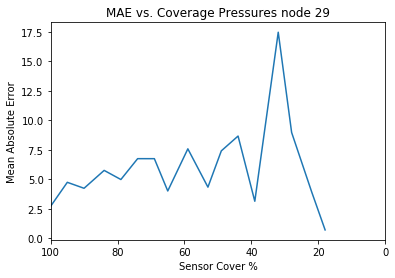

In [6]:
#run this after cell above finishes training 
plt.plot(sensors_covered, maximum_MAE)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Pressures node 29")
plt.xlim([100, 0])
#plt.savefig('/Users/alexellard/Downloads/Node29Pressure.png')
plt.show()

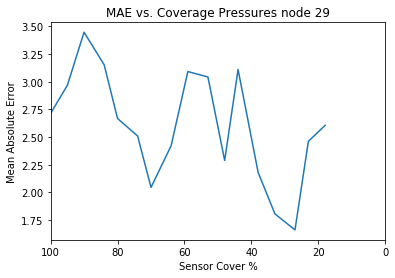

In [7]:
#run this after cell above finishes training 
plt.plot(sensors_covered, MAE_average)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Pressures node 29")
plt.xlim([100, 0])
#plt.savefig('/Users/alexellard/Downloads/Link16FlowsMax.png')
plt.show()

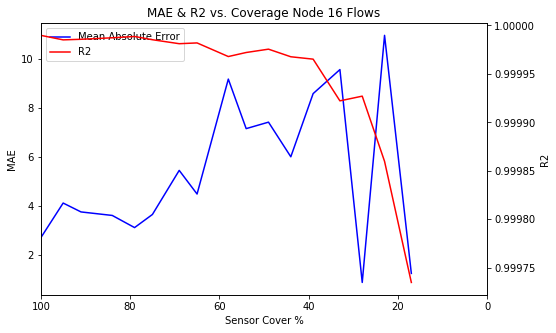

In [10]:
# Create the plot and specify the figure size
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot the first line
ax1.plot(sensors_covered, maximum_MAE, 'b-', label='Mean Absolute Error')
ax1.set_xlabel('Sensor Cover %')
ax1.set_ylabel('MAE')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the second line
ax2.plot(sensors_covered, R2_average, 'r-', label='R2')
ax2.set_ylabel('R2')

# Show legends for both lines
lines = [ax1.get_lines()[0], ax2.get_lines()[0]]
ax1.legend(lines, [line.get_label() for line in lines])

# Show the plot
plt.title("MAE & R2 vs. Coverage Node 16 Flows")
plt.xlim([100, 0])
plt.savefig('/Users/alexellard/Downloads/MAER2Pressure.png')
plt.show()
